In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
from importlib import reload
import random
from functools import reduce, partial
from os.path import join
from time import time
import os

from tqdm import tqdm
import pandas as pd
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import pytorch_lightning as pl
import skimage.morphology as morp
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from PIL import Image, ImageDraw
import torchviz
# from deep_morpho.datasets.mnist_dataset import MnistClassifDataset
# from deep_morpho.models import LightningBiMoNNClassifier, BiSE, COBiSE, BiSEC, COBiSEC


import deep_morpho.models.softplus as sfp
import general.array_morphology as arm
import general.structuring_elements as selm
from general.nn.loss import DiceLoss

import deep_morpho.initializer.bise_initializer as bise_init
import deep_morpho.initializer.bisel_initializer as bisel_init
import deep_morpho.initializer.bimonn_initializer as bimonn_init
import deep_morpho.initializer as inits

import deep_morpho.loss as dmloss
import deep_morpho.threshold_fn as threshold_fn
import deep_morpho.morp_operations as morpop
import deep_morpho.models.threshold_layer as threshold_layer
import deep_morpho.models.complementation_layer as complementation_layer
import deep_morpho.models.pconv as pconv
import deep_morpho.models.lightning_pconv as lpconv
import deep_morpho.models.bise_base as bise_base
import deep_morpho.models.bise as bise
import deep_morpho.models.lui as lui
import deep_morpho.models.bisel as bisel
import deep_morpho.models.cobise as cobise
import deep_morpho.models.dilation_sum_layer as dis
import deep_morpho.models.bimonn as bimonn
import deep_morpho.models as models
import deep_morpho.models.lightning_bise as lbise
import deep_morpho.models.lightning_cobise as lcobise
import deep_morpho.models.lightning_bimonn as lbimonn
import deep_morpho.datasets.generate_forms1 as gfo
import deep_morpho.datasets.generate_forms2 as gfo2
import deep_morpho.datasets.generate_forms3 as gfo3
import deep_morpho.datasets.axspa_roi_dataset as axd
import deep_morpho.datasets.multi_rect_dataset as mrda
import deep_morpho.datasets.mnist_dataset as mnist_dataset
import deep_morpho.observables.plot_parameters as obs_weights
import deep_morpho.observables.plot_pred as obs_pred
import deep_morpho.observables.weight_histogram as weight_histogram
import deep_morpho.observables as obs
import general.nn.viz.plot_histogram as phist
import general.nn.viz.element_image as eltimage
import general.nn.viz.element_histogram as elthistogram
import deep_morpho.viz.morp_operations_viz as mov
import deep_morpho.viz.elt_generator_bimonn_forward_save as eltgenbifor
import deep_morpho.viz.elt_generator_bimonn_histogram as eltgenbihist
import deep_morpho.viz.bimonn_viz as bimonn_viz

def reload_modules():
    for modl in [bise_init, bisel_init, bimonn_init, inits, sfp, arm, dmloss, selm, threshold_fn, morpop,
                 threshold_layer,complementation_layer, pconv, lpconv, bise_base, bise, lui, bisel, cobise,
                 dis, bimonn, models, lbise, lbimonn, lcobise, gfo, gfo2, gfo3, axd,
                 mrda, mnist_dataset, obs_weights, obs_pred, obs,
                weight_histogram, phist, eltimage, elthistogram, mov, eltgenbifor, eltgenbihist, bimonn_viz]:
        reload(modl)
        
reload_modules()

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

cuda


In [3]:
def plot_horizontal(imgs, title=None):
    n_figs = len(imgs)
    fig = plt.figure(figsize=(5*n_figs, 5))
    for idx in range(1, n_figs + 1):
        ax = fig.add_subplot(1, n_figs, idx)
        ax.imshow(imgs[idx-1])
        if title is not None:
            ax.set_title(title[idx-1])


# In search of a soft tresholding function ...

First guess:
$$x \mapsto \sigma_{\alpha, \epsilon}(x) = \sigma\big[\alpha(x - \epsilon)\big] = \frac{1}{1 + e^{-\alpha(x - \epsilon)}}$$
with $\epsilon$ the threshold and $\alpha > 0$ the tightness of thresholding.

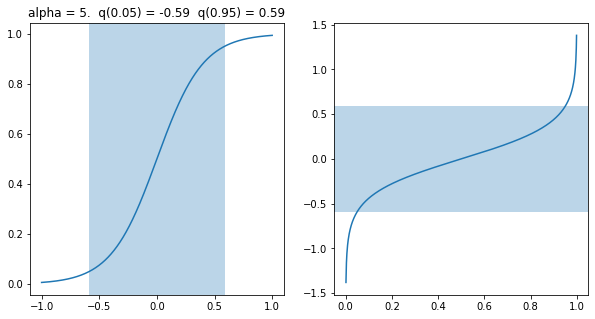

In [234]:
def sigma_inv(y, alpha):
    return -1 / alpha * np.log(1 / y - 1)

def sigma(y, alpha):
    return 1 / (1 + np.exp(- alpha * x))

N = 1000
ALPHA = 5
q1 = sigma_inv(0.05, ALPHA)
q2 = sigma_inv(0.95, ALPHA)

fig = plt.figure(figsize=(10, 5))

x = np.linspace(-1, 1, N)
y = sigma(x, ALPHA)
ax = fig.add_subplot(121)
ax.plot(x, y)
ax.set_title(f"alpha = {ALPHA}.  q(0.05) = {round(q1, 2)}  q(0.95) = {round(q2, 2)}")
ax.axvspan(q1, q2, alpha=.3,)

x = np.linspace(0.001, 0.999, N)
y = sigma_inv(x, ALPHA)
ax = fig.add_subplot(122)
ax.plot(x, y)
ax.axhspan(q1, q2, alpha=.3)


# Dataset

## Rectangles

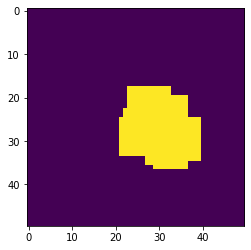

In [11]:
reload_modules()
x, rect_args = gfo.random_multi_rect(
    size=(50, 50), 
    n_rectangles=8,
    max_shape=(10, 10),
    return_rects=True, 
    first_rect_args={
        "top_left_x_props": (.3, .7),
        "top_left_y_props": (.3, .7)
    }
)
plt.imshow(x)


torch.Size([4, 1, 50, 50]) torch.Size([4, 50, 50])
CPU times: user 657 ms, sys: 8.74 ms, total: 666 ms
Wall time: 418 ms


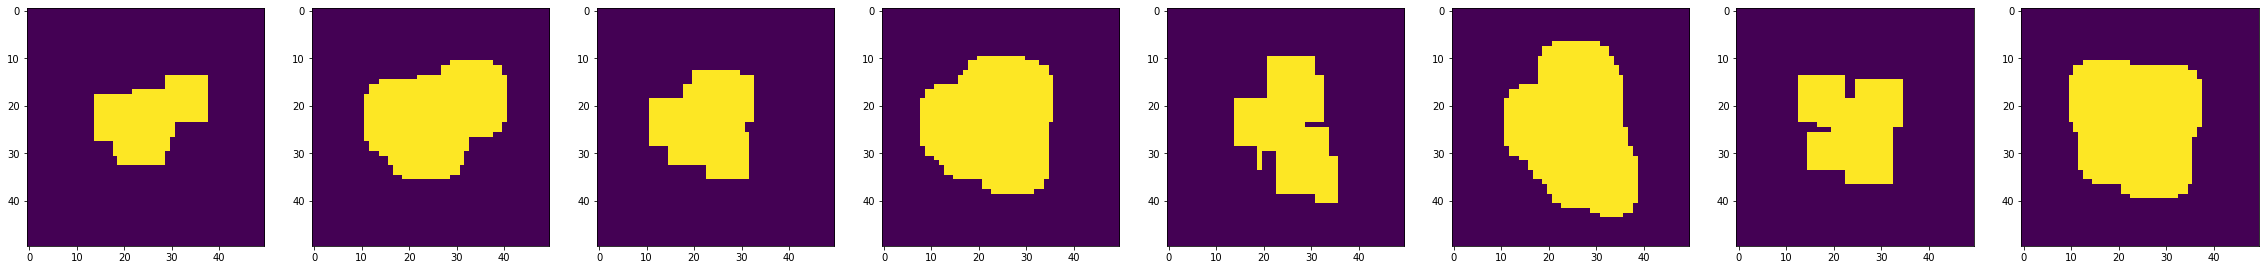

In [6]:
%%time
reload_modules()
dataset = mrda.MultiRectDataset(size=(50, 50), n_rectangles=8, max_shape=(10, 10), selem=morp.disk(3))
# input_, target = dataset[0]
dataloader = DataLoader(dataset, batch_size=4)

inputs, targets = next(iter(dataloader))
print(inputs.shape, targets.shape)

plot_horizontal(
    reduce(lambda a,b: a+b, 
           [[inpt[0].cpu(), target.cpu()] for (inpt, target) in zip(inputs, targets)]))

## Disks

In [29]:
ar = np.zeros((50, 50))
radius = 10
center = (14, 31)

XX, YY = np.meshgrid(np.arangee(ar.shape[0]), np.arange(ar.shape[1]))

In [31]:
idxes = np.sqrt((XX - center[0])**2 + (YY - center[1])**2) - radius

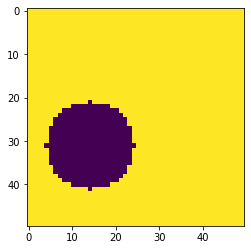

In [33]:
plt.imshow(idxes > 0)

In [89]:
min(center_x - min_x, max_x - center_x, max_shape[0] // 2)

5

In [346]:
reload_modules()
size = (50, 50)
n_shapes = 10
max_shape = (10, 10)
borders = (.1, .9)

all_diskorect = [np.zeros(size)]
min_x, min_y = int(size[0] * borders[0]), int(size[1] * borders[0])
max_x, max_y = int(size[0] * borders[1]), int(size[1] * borders[1])



In [194]:
min(center_x - min_x, max_x - center_x, max_shape[0] // 2)

2

In [207]:
max_shape[0]//2

5

center pre clip 24 48
center: 24 43
W1 W2 L1 L2 22 26 41 44
802.0


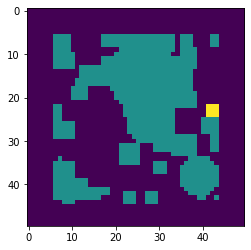

In [400]:

diskorect = all_diskorect[-1] + 0
not_0 = np.where(1 - diskorect)
rand_idx = random.choice(range(len(not_0[0])))
center_x, center_y = not_0[0][rand_idx], not_0[1][rand_idx]

print("center pre clip", center_x, center_y)
center_x = min(max_x - 2, max(min_x + 2, center_x))
center_y = min(max_y - 2, max(min_y + 2, center_y))

print("center:", center_x, center_y)

if np.random.rand() > .5:
    W1 = np.random.randint(1, min(center_x - min_x, max_shape[0] // 2))
    W2 = np.random.randint(1, min(max_x - center_x, max_shape[0] // 2))

    L1 = np.random.randint(1, min(center_y - min_y, max_shape[1] // 2))
    L2 = np.random.randint(1, min(max_y - center_y, max_shape[1] // 2))

    diskorect[center_x-W1:center_x+W2, center_y-L1:center_y+L2] = 1
    print("W1 W2 L1 L2", center_x-W1, center_x+W2, center_y-L1, center_y+L2)


else:
    radius = np.random.randint(1, min(center_x - min_x, max_x - center_x, max_shape[0]))
    radius = min(max_x - center_x, center_x - min_x, max_y - center_y, center_y - min_y, radius)
    gfo2.draw_disk(diskorect, (center_x, center_y), radius)
    print("r=", radius)

all_diskorect.append(diskorect)

disko_to_show = diskorect + 0
disko_to_show[(diskorect - all_diskorect[-2]).astype(bool)] = 2
plt.imshow(disko_to_show)
print(diskorect.sum())

In [336]:
all_diskorect[-2][39, 29]

1.0

In [414]:
reload_modules()
drc = gfo2.get_random_diskorect((50, 50), 30, (15, 15),)

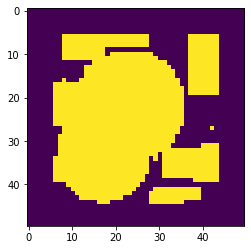

In [415]:
plt.imshow(drc)

In [ ]:
plt.imshow(drc)

## Diskorect

In [4]:
%%timeit 
gfo3.get_random_rotated_diskorect(
    size=(100, 100), 
    n_shapes=30,
    max_shape=(15, 15),
    p_invert=0.5,
    border=(4, 4),
    n_holes=30,
    max_shape_holes=(7, 7),
    noise_proba=0.1
)

776 µs ± 92.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


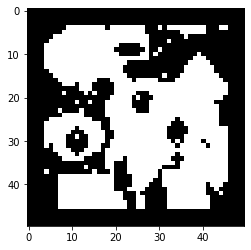

In [5]:
reload_modules()
x = gfo3.get_random_rotated_diskorect(
    size=(50, 50), 
    n_shapes=30,
    max_shape=(15, 15),
    p_invert=0.5,
    border=(4, 4),
    n_holes=15,
    max_shape_holes=(7, 7),
    noise_proba=0.05
)
plt.imshow(x, cmap='gray')


In [5]:
np.random.rand(5, 5)

array([[0.9383361 , 0.16752919, 0.3532739 , 0.51804779, 0.06744834],
       [0.0137424 , 0.8589926 , 0.26945179, 0.90185226, 0.41456367],
       [0.1401719 , 0.8642328 , 0.91726109, 0.05157154, 0.97386763],
       [0.54366318, 0.32952966, 0.9625261 , 0.35044086, 0.67201862],
       [0.78542865, 0.28926045, 0.56488438, 0.47357603, 0.10997295]])

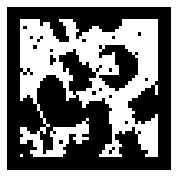

In [13]:
reload_modules()
h, w = 1, 1
fig, axs = plt.subplots(h, w, figsize=(w*3, h*3), squeeze=False)
for idx1 in range(h):
    for idx2 in range(w):
        x = gfo3.get_random_rotated_diskorect(
            size=(50, 50), 
            n_shapes=30,
            max_shape=(15, 15),
            p_invert=0.5,
            border=(4, 4),
            n_holes=15,
            max_shape_holes=(7, 7),
            noise_proba=0.05
        )
        axs[idx1, idx2].imshow(x, cmap='gray')
        axs[idx1, idx2].axis('off')


In [14]:
fig.savefig("diskorect2.eps")

## Axspa ROI

In [4]:
df = pd.read_csv('data/deep_morpho/axspa_roi/axspa_roi.csv')

In [30]:
reload_modules()
dataset = axd.AxspaROISimpleDataset(pd.read_csv('data/deep_morpho/axspa_roi/axspa_roi.csv'))
dataloader = axd.AxspaROISimpleDataset.get_loader(
    data=pd.read_csv('data/deep_morpho/axspa_roi/axspa_roi.csv'),
    batch_size=4,
    shuffle=True
)

(-0.5, 511.5, 511.5, -0.5)

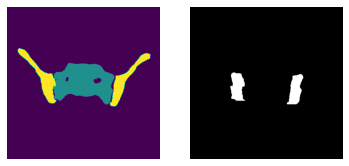

In [31]:
inpt, target = dataset[104]
all_chans = np.zeros(inpt.shape[1:])
all_chans[inpt[0] == 1] = 1
all_chans[inpt[1] == 1] = 2

fig = plt.figure(figsize=(6, 3))

ax = fig.add_subplot(121)
ax.imshow(all_chans)
ax.axis('off')

ax = fig.add_subplot(122)
ax.imshow(target[0], cmap='gray')
ax.axis('off')


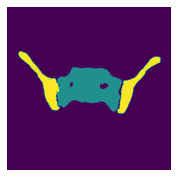

In [33]:
fig = plt.figure(figsize=(3, 3))
plt.imshow(all_chans)
plt.axis('off')
fig.savefig("axspa_input.eps")

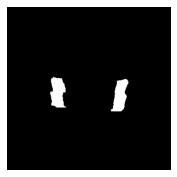

In [35]:
fig = plt.figure(figsize=(3, 3))
plt.imshow(target[0], cmap='gray')
plt.axis('off')
fig.savefig("axspa_target.eps")

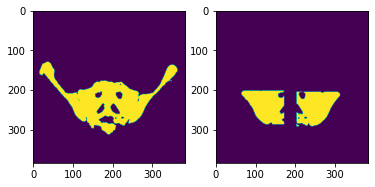

In [136]:
inpts, targets = next(iter(dataloader))

plt.subplot(121)
plt.imshow(inpts[0, 0].cpu())

plt.subplot(122)
plt.imshow(targets[0, 0].cpu())

In [81]:
inpts[0, 0].shape

torch.Size([528, 528])

## Mnist

### Segmentation

In [34]:
reload_modules()
dataset = mnist_dataset.MnistMorphoDataset(
    morp_operation=morpop.ParallelMorpOperations.erosion(('disk', 1)),
    n_inputs="all",
    train=False,
    threshold=.01,
    size=(28, 28)
)

dataloader = mnist_dataset.MnistMorphoDataset.get_loader(
    batch_size=4, n_inputs=1000, 
    morp_operation=morpop.ParallelMorpOperations.erosion(('bdiamond', 7)),
    train=True, shuffle=True, size=(28, 28)
)

In [68]:
ops = ["bcomplex", "scross", "bdiamond"]
sum_value = {op: [] for op in ops}

for op in ops:
    dataloader = mnist_dataset.MnistMorphoDataset.get_loader(
        batch_size=1, n_inputs="all", 
        morp_operation=morpop.ParallelMorpOperations.erosion((op, 7)),
        train=True, shuffle=True, size=(28, 28), threshold=(1/2),
    )
    for img, tar in tqdm(dataloader):
        img = img[0]
        tar = tar[0]

        sum_value[op].append(tar.sum().item(),)
    sum_value[op] = np.array(sum_value[op])


# plt.subplot(121)
# plt.imshow(img[0], cmap='gray')

# plt.subplot(122)
# plt.imshow(tar[0], cmap='gray')


100%|██████████| 60000/60000 [00:31<00:00, 1879.62it/s]


In [69]:
plt.figure(figsize=(15, 5))
max_bin = 40
for idx, op in enumerate(ops):
    plt.subplot(1, 3, idx+1)
    bins = np.arange(-0.5, max_bin + 0.5)
    plt.hist(sum_value[op],  bins=bins, label='pdf', density=True);
    plt.title(f"{op} {(sum_value[op] == 0).mean()*100:.0f}% at 0")

    # plt.subplot(2, 3, 3 + idx + 1)
    count, bins_count = np.histogram(sum_value[op], bins=bins)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    plt.plot(np.arange(max_bin), cdf, label='cdf')
    plt.legend()

    plt.grid('on')



plt.suptitle("Erosion sum 60000 samples")

Text(0.5, 0.98, 'Erosion sum 60000 samples')

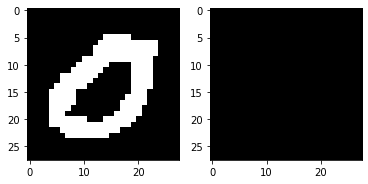

In [73]:
dataloader = mnist_dataset.MnistMorphoDataset.get_loader(
    batch_size=4, n_inputs=1000, 
    morp_operation=morpop.ParallelMorpOperations.erosion(('bdiamond', 7)),
    train=True, shuffle=True, size=(28, 28), threshold=1/2
)

img, tar = next(iter(dataloader))

plt.subplot(121)
plt.imshow(img[0, 0], cmap='gray')

plt.subplot(122)
plt.imshow(tar[0, 0], cmap='gray')

Text(0.5, 1.0, 'thresholded')

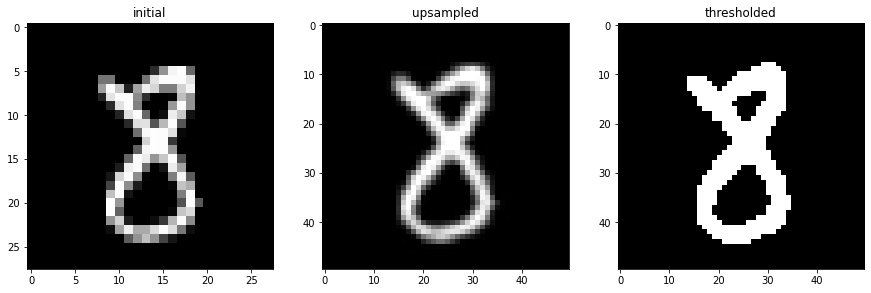

In [7]:
img = dataset.data[401]


plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.title('initial')

img2 = cv2.resize(img.numpy(), (50, 50), interpolation=cv2.INTER_CUBIC)
plt.subplot(132)
plt.imshow(img2, cmap="gray")
plt.title('upsampled')

plt.subplot(133)
plt.imshow(img2 > 50, cmap='gray')
plt.title('thresholded')


In [28]:
fig = plt.figure(figsize=(3, 3))
plt.imshow((img2 > 50), cmap='gray')
plt.axis('off')
fig.savefig("mnist.eps")

In [94]:
img, target = next(iter(dataloader))

plot_horizontal([img[0, 0], target[0, 0]])

/hdd/aouadt/these/projets/3d_segm/deep_morpho/morp_operations.py:327: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)


### Classification

In [32]:
reload_modules()
dataset = mnist_dataset.MnistClassifDataset(
    n_inputs="all",
    train=False,
    threshold=.01,
)

dataloader = mnist_dataset.MnistClassifDataset.get_loader(
    batch_size=4, n_inputs=1000, 
    train=True, shuffle=True
)

Text(0.5, 1.0, 'tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])')

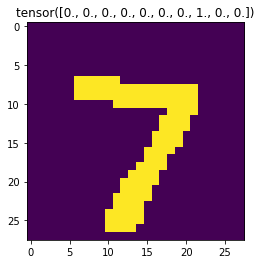

In [82]:
img, target = dataset[0]
plt.imshow(img[0])
plt.title(target)

Text(0.5, 1.0, 'tensor([[[0., 0., 0.,  ..., 0., 0., 0.],\n         [0., 0., 0.,  ..., 0., 0., 0.],\n         [0., 0., 0.,  ..., 0., 0., 0.],\n         ...,\n         [0., 0., 0.,  ..., 0., 0., 0.],\n         [0., 0., 0.,  ..., 0., 0., 0.],\n         [0., 0., 0.,  ..., 0., 0., 0.]]])')

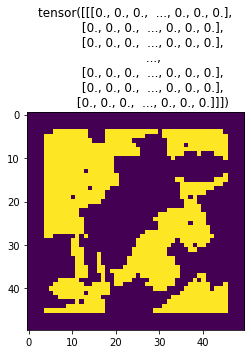

In [75]:
img, target = next(iter(dataloader))
plt.imshow(img[0, 0])
plt.title(target[0])

In [86]:
fig, ax = plt.subplots(2, 1)
colors = ["red" for _ in range(10)]
colors[target[0].argmax()] = "green"
ax[0].barh(np.arange(10), target, tick_label=range(10), color=colors)
ax[0].set_xlim(0, 1)
for idx, value in enumerate(target):
    ax[0].text(value, idx, f"{value.item():.2f}", fontsize=12, ha='left')

In [85]:
target.shape

torch.Size([10])

## Dataloader

In [12]:
morp_operation = morpop.ParallelMorpOperations.erosion(('disk', 3))
dataloader = mrda.InputOutputGeneratorDataset.get_loader(
    random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={'size': (50, 50), 'n_shapes': 20, 'max_shape': (20, 20), 'p_invert': 0.5, 'n_holes': 10, 'max_shape_holes': (10, 10), 'noise_proba': 0.02},
    morp_operation=morp_operation,
    n_inputs=100,
    batch_size=100,
    generate_infinite=True,
    num_workers=0,
)

dataloader2 = mrda.InputOutputGeneratorDataset.get_loader(
    random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={'size': (50, 50), 'n_shapes': 20, 'max_shape': (20, 20), 'p_invert': 0.5, 'n_holes': 10, 'max_shape_holes': (10, 10), 'noise_proba': 0.02},
    morp_operation=morp_operation,
    n_inputs=100 * 100,
    batch_size=100,
    generate_infinite=True,
    num_workers=0,
)


In [13]:
%%time
for _ in range(int(1e2)):
    for batch in dataloader:
        pass

CPU times: user 2min 17s, sys: 90.5 ms, total: 2min 17s
Wall time: 11.5 s


In [14]:
%%time
for batch in dataloader2:
    pass

CPU times: user 2min 14s, sys: 132 ms, total: 2min 14s
Wall time: 11.3 s


# Net

## BiSE

In [7]:
reload_modules()

selem = morp.disk(4)
net = bise.BiSE.bise_from_selem(selem, "dilation", weight_P = 5)
net.conv.weight.data = net.conv.weight.data + torch.rand(net.conv.weight.data.shape) / 10

In [8]:
%%time
net.find_selem_and_operation_chan(0)

CPU times: user 3.16 ms, sys: 0 ns, total: 3.16 ms
Wall time: 2.31 ms


(array([[False, False, False, False,  True, False, False, False, False],
        [False, False,  True,  True,  True,  True,  True, False, False],
        [False,  True,  True,  True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True,  True,  True, False],
        [False, False,  True,  True,  True,  True,  True, False, False],
        [False, False, False, False,  True, False, False, False, False]]),
 'dilation')

In [10]:
%%time
weight_values = net._normalized_weight.unique()
possible_values = (weight_values >= -net.bias[0])
net.is_dilation_by(
    net._normalized_weight[0, 0],
    net.bias[0],
    (net._normalized_weight >= weight_values[possible_values][0]).squeeze().cpu().detach().numpy()
)


CPU times: user 3.38 ms, sys: 0 ns, total: 3.38 ms
Wall time: 2.62 ms


tensor(True)

In [20]:
reload_modules()
net = bise.BiSE((7, 7))

In [23]:
net.find_closest_selem_and_operation_chan(0, )

(array([[False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False]]),
 'dilation',
 12.631749)

In [16]:
net._normalized_weight

tensor([[[[0.2545, 0.3041, 0.3222, 0.2288, 0.3238, 0.2319, 0.2436],
          [0.3751, 0.3237, 0.2633, 0.3169, 0.2688, 0.2800, 0.3529],
          [0.3472, 0.2508, 0.3233, 0.2579, 0.2382, 0.2103, 0.1749],
          [0.3163, 0.3901, 0.2533, 0.8253, 0.2500, 0.1981, 0.2915],
          [0.2876, 0.2653, 0.2536, 0.2127, 0.3785, 0.2326, 0.2806],
          [0.2544, 0.2250, 0.2896, 0.2587, 0.2529, 0.3269, 0.1887],
          [0.2229, 0.3557, 0.2040, 0.1945, 0.2027, 0.3239, 0.2309]]]],
       grad_fn=<SigmoidBackward>)

In [14]:
reload_modules()
x = torch.ones((3, 1, 50, 50))

net = bise.BiSE(kernel_size=(50, 50), padding=0, stride=25)
net(x)

tensor([[[[1.]]],


        [[[1.]]],


        [[[1.]]]], grad_fn=<SigmoidBackward>)

In [25]:
net = nn.Conv2d(1, 1, (50, 50))
net.weight.data = torch.ones_like(net.weight)
net(x)

tensor([[[[2499.9868]]],


        [[[2499.9868]]],


        [[[2499.9868]]]], grad_fn=<MkldnnConvolutionBackward>)

In [37]:
torch.ones(1, 1, 1, 1).squeeze(-1).squeeze(-1).shape

torch.Size([1, 1])

## Bisel

In [4]:
net = bisel.BiSEL()

<module 'deep_morpho.models.bisel' from '/hdd/aouadt/these/projets/3d_segm/deep_morpho/models/bisel.py'>

## DilationSum

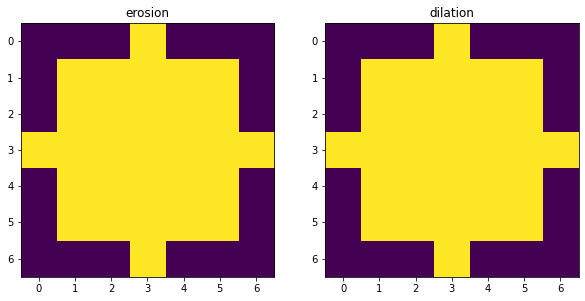

In [5]:
reload_modules()

morp_operation = arm.SequentialMorpOperations(
    name="opening", 
    selems=[morp.disk(3), morp.disk(3)],
    operations=['erosion', 'dilation'],
    device=device
)

plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5,
                    'border': (4, 4)},
    device=device,
    morp_operation=morp_operation,
)



In [ ]:
img, target = next(iter(dataloader))

In [69]:
reload_modules()
net = dis.DilationSumLayer(kernel_size=(5, 5), padding=2)
net.to(device)

DilationSumLayer(
  (unfolder): Unfolder()
  (maxpool): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
)

In [59]:
net.kron_weight(img.shape[-2:]).shape

torch.Size([230, 230])

In [52]:
net.unfolder._right_operator[torch.Size([50, 50])].shape

torch.Size([50, 230])

In [67]:
net.unfolder(img[0, 0]).shape

torch.Size([240, 240])

In [70]:
net(img).shape

torch.Size([32, 1, 50, 50])

# Parallel Morp Operations Tests

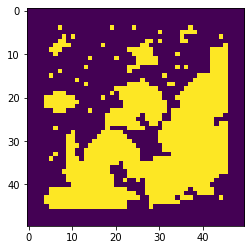

In [6]:
x = gfo3.get_random_diskorect_channels(
    size=(50, 50, 1), 
    n_shapes=30,
    max_shape=(15, 15),
    p_invert=0.5,
    border=(4, 4),
    n_holes=15,
    max_shape_holes=(7, 7),
    noise_proba=0.05
)
plt.imshow(x)

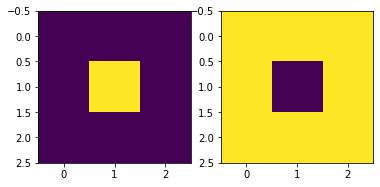

In [50]:
reload_modules()

W = 3

selem1 = np.zeros((W, W))
selem1[1:-1, 1:-1] = selm.disk(W // 2 - 1)

selem2 = np.ones((W, W))
selem2[1:-1, 1:-1] = 0

mp = morpop.ParallelMorpOperations.hit_or_miss_transform(selem1, selem2)
# mp = morpop.ParallelMorpOperations.erosion(selem1)
identity = ('dilation', ('identity', 3), False)
mp = morpop.ParallelMorpOperations(
    operations=[
        [
            [identity, 'union'],
            [identity, 'union'],
            [identity, 'union'],
            [identity, 'union'],
        ],
        [
            [identity, ('erosion', selem1, True), identity, identity, ('intersection', [0, 1])],
            [identity, identity, identity, ('dilation', selem2, False), ('intersection', [2, 3])],
        ],
        [
            [identity, identity, 'union']
        ]
    ]
)

outp = mp(x)

plt.subplot(121)
plt.imshow(selem1)

plt.subplot(122)
plt.imshow(selem2)


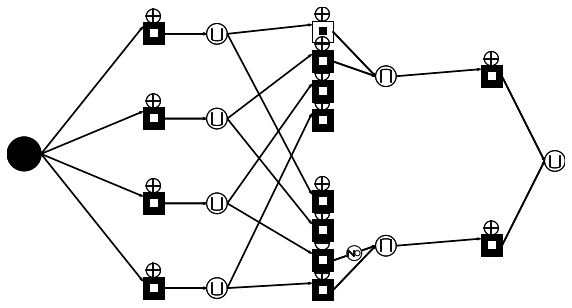

In [51]:
disp = mov.MorpOperationsVizualiser(mp)
disp.draw(figsize=(10, 10))

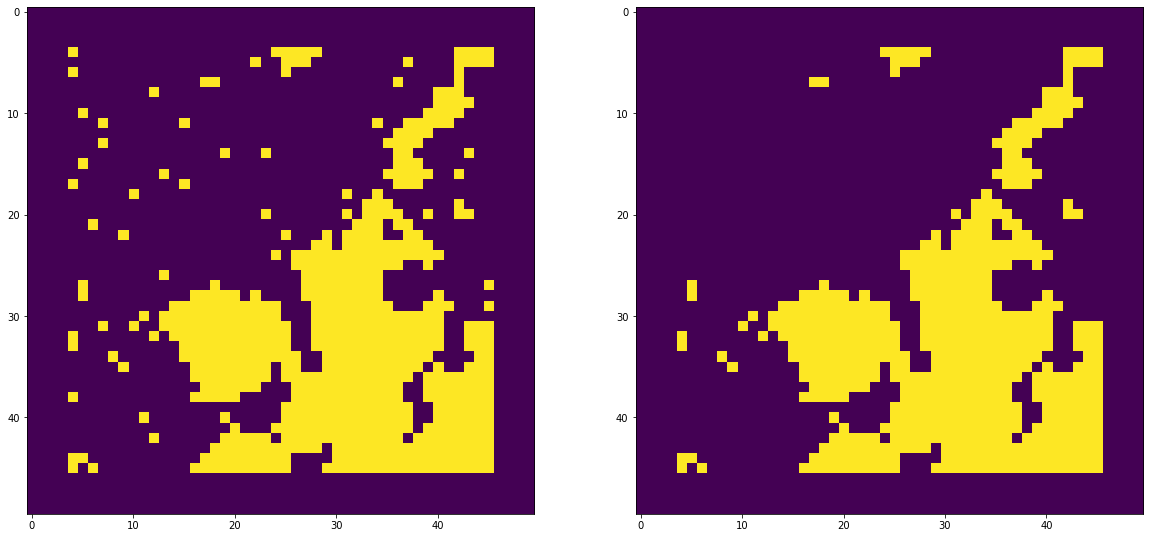

In [52]:
plt.figure(figsize=(20, 20))

plt.subplot(121)
plt.imshow(x)

plt.subplot(122)
plt.imshow(outp)

In [13]:
selem = np.array([[0, 0, 1]])
np.ones((3, 3))[np.where(selem)]

array([1.])

In [62]:
x = np.zeros((10, 10, 1))
x[4, 4, 0] = 1

In [72]:
import copy
mop2 = copy.deepcopy(mop)

In [73]:
mop2.operations.append("banana")

In [76]:
l = [1, 2, 3]
l.extend([3, 3])

In [77]:
l

[1, 2, 3, 3, 3]

In [75]:
mop.operations

[[[<function deep_morpho.morp_operations.ParallelMorpOperations._erodila_op_converter.<locals>.<lambda>(x)>,
   <function deep_morpho.morp_operations.ParallelMorpOperations._ui_converter.<locals>.<lambda>(x)>]]]

In [70]:
reload_modules()
# selem = np.zeros((3, 3))
# selem[0, 1] = 1
mop = morpop.ParallelMorpOperations.translation(3, 0)

plt.subplot(121)
plt.imshow(x)

plt.subplot(122)
plt.imshow(mop(x))

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


# Duality Learning

In [43]:
reload_modules()

morp_operation = arm.SequentialMorpOperations(
    name="dilation", 
    selems=[('dcross', 7)],
    operations=['dilation'],
    device='cpu'
)

plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = mrda.MultiRectDatasetGenerator.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5,
                    'border': (4, 4)},
    device='cpu',
    morp_operation=morp_operation,
)



In [62]:
imgs, targets = next(iter(dataloader))
img = imgs[0, 0]
target = targets[0]

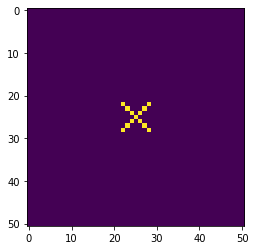

In [63]:
plt.imshow(arm.array_erosion(ar=target, selem=img))

# Training

## Dilation / Erosion

Opening 49


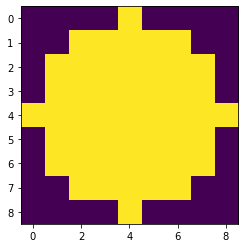

In [118]:
reload_modules()

# morp_operation = 'Dilation'
# morp_operation = 'Erosion'
morp_operation = 'Opening'

# selem = np.zeros((5, 5))
# selem[np.arange(5), 5 - np.arange(1, 6)] = 1
# selem[np.arange(5), np.arange(5)] = 1
# selem[:, 2] = 1
# selem[2, :] = 1
selem = morp.disk(4)
plt.imshow(selem)
print(morp_operation, selem.sum())

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=500_000,
#     random_gen_fn=gfo.random_multi_rect,
#     random_gen_args={
#         'size': (50, 50), 
#         'n_rectangles': 8,
#         'max_shape': (10, 10), 
#     },
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5},
    device=device, 
    selem=selem,
    morp_operation=morp_operation,
)

0


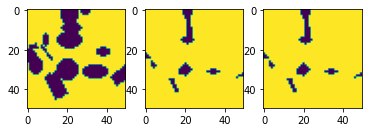

In [139]:
img, target = next(iter(dataloader))
img = img[0, 0].detach().cpu()

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(img)

selems = []

selem = np.zeros((5, 5))
selem[2, :] = 1
selems.append(selem)

selem = np.zeros((5, 5))
selem[:, 2] = 1
selems.append(selem)


morp_fn = arm.sequentiel_morp_operations(
    img,
    selems=selems,
    operations=['dilation', 'dilation']
)

oimg = morp_fn(img)
ax = fig.add_subplot(132)
ax.imshow(oimg)

oimg2 = arm.array_dilation(img, selem=np.ones((5, 5)))
ax = fig.add_subplot(133)
ax.imshow(oimg2)

print((oimg - oimg2).sum())

In [130]:
img.shape

torch.Size([50, 50])

In [11]:
reload_modules()
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

if morp_operation.lower() != "opening":
    observables = [
        obs.PlotParametersDilation(100),
        obs.PlotPreds(100),
        obs.WeightsHistogramDilation(1000)
    ]
    
    model = lbise.LightningBiSE(
        model_args={
            "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5)
        },
        learning_rate=1e-2,
        loss=loss,
        optimizer=optimizer,
        output_dir="deep_morpho/results",
        observables=observables
    )
else:
    observables = [
        obs.PlotParametersMultipleDilations(1),
        obs.PlotPreds(1),
        obs.WeightsHistogramMultipleDilations(1)
    ]
    
    model = lon.LightningOpeningNet(
        model_args={
            "share_weights": True, "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5)
        },
        learning_rate=5e-2,
        loss=loss,
        optimizer=optimizer,
        output_dir="deep_morpho/results",
        observables=observables
    )


model.to(device)

logger = TensorBoardLogger("deep_morpho/results", name=morp_operation)
print(logger.log_dir)

logger.experiment.add_graph(model, torch.ones(1, 1, 50, 50).to(device))
logger.experiment.add_image("target_SE", selem[np.newaxis, :].astype(float))

trainer = Trainer(
    max_epochs=1,
    gpus=1 if torch.cuda.is_available() else 0,
    logger=logger,
    progress_bar_refresh_rate=10,
    callbacks=observables.copy()
)

trainer.fit(model, dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | OpeningNet        | 55    
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
55        Trainable params
0         Non-trainable params
55        Total params
0.000     Total estimated model params size (MB)


deep_morpho/results/Opening/version_13


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [68]:
img, target = dataloader.dataset[0]
otp = model(img.unsqueeze(0).cpu())


- Unet Version 15: training on $3 \cdot 10^8$ images with softmax before weight
- Dilation Version 0: training on $3 \cdot 10^8$ images without softmax, max min norm

In [103]:
model = model.load_from_checkpoint(join("deep_morpho/results/Unet/version_15/checkpoints/epoch=0-step=93749.ckpt"))

<ipython-input-3-2732c24916c7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5*n_figs, 5))


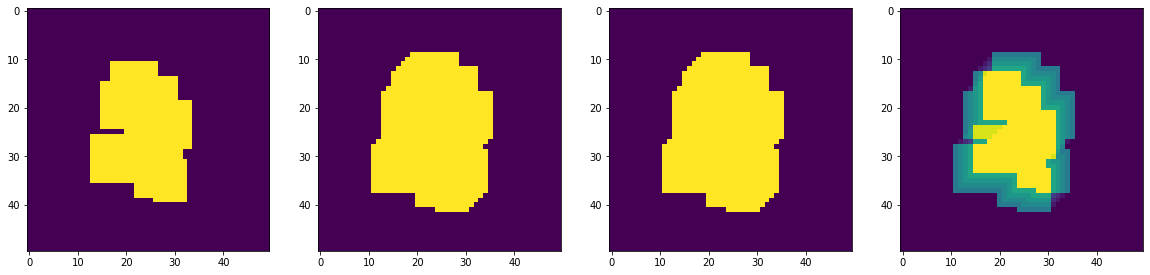

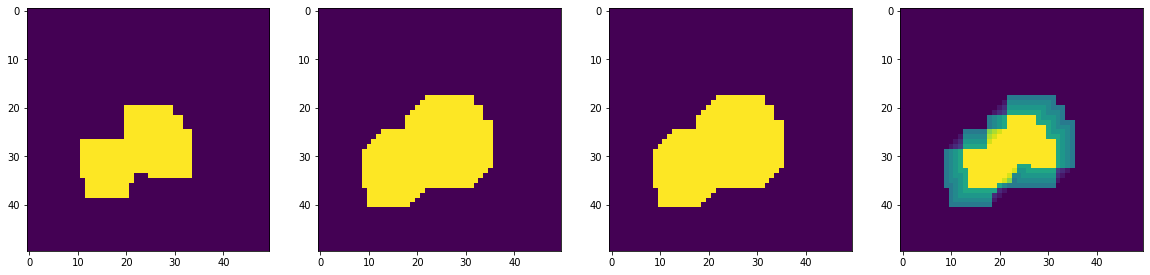

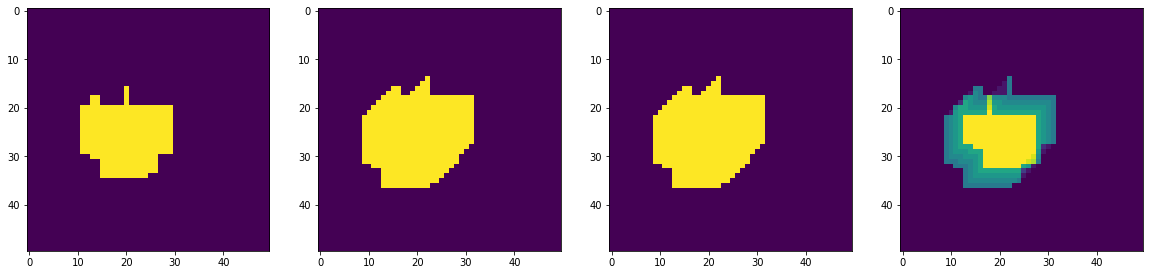

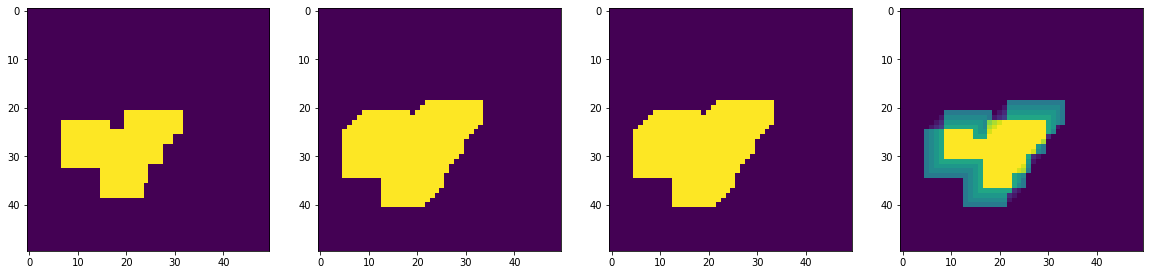

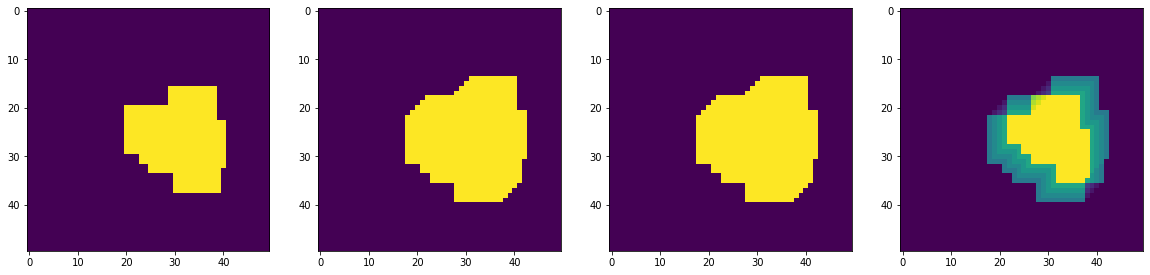

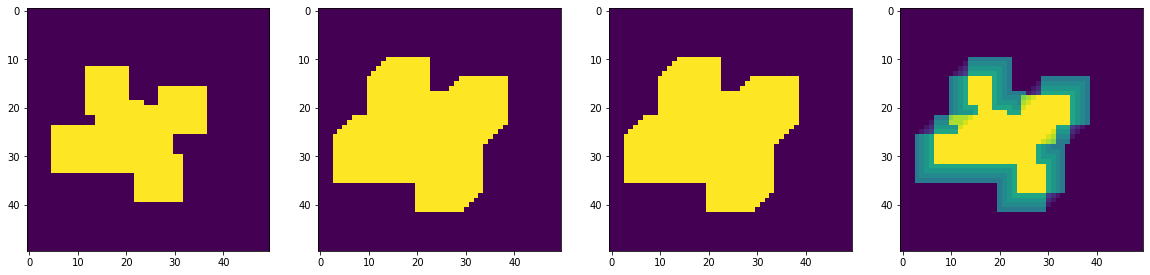

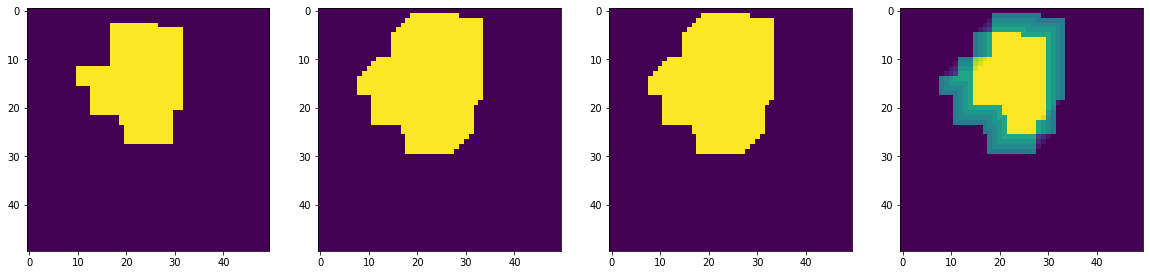

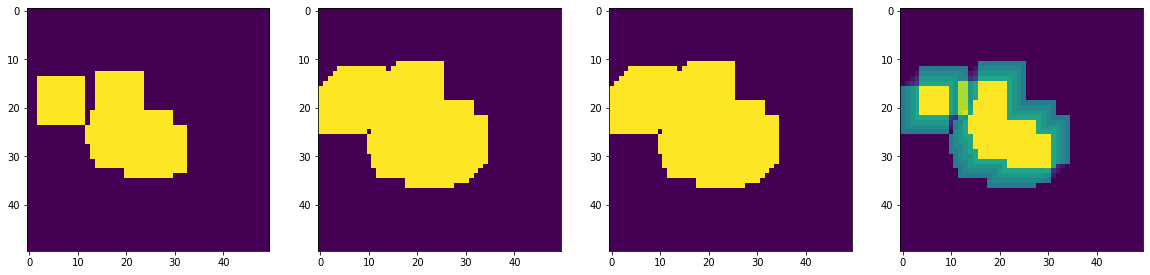

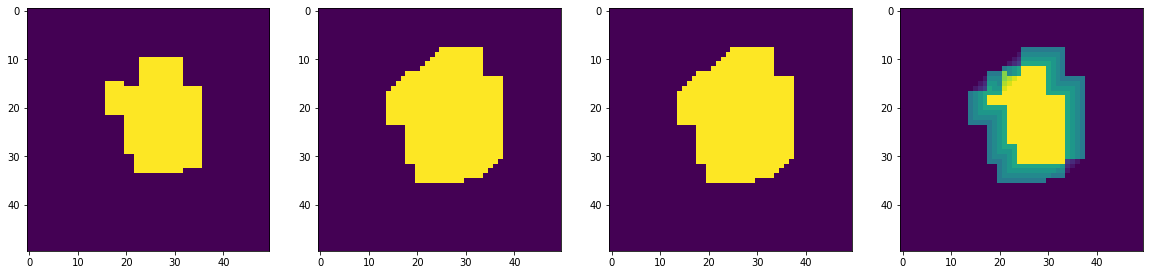

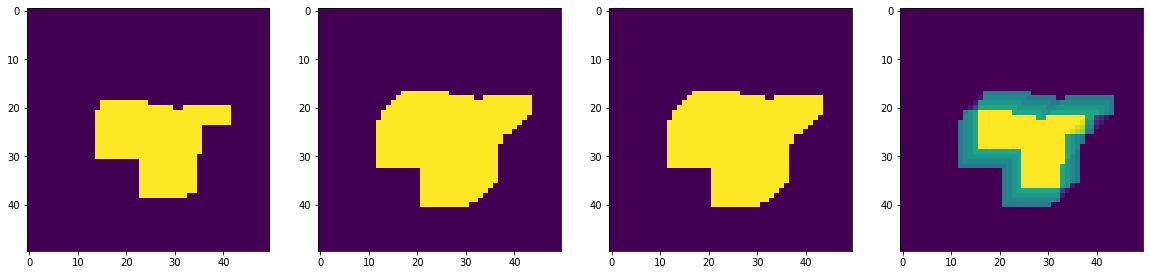

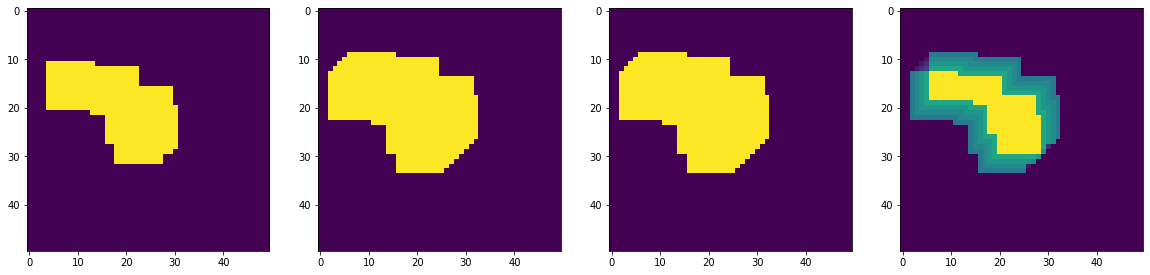

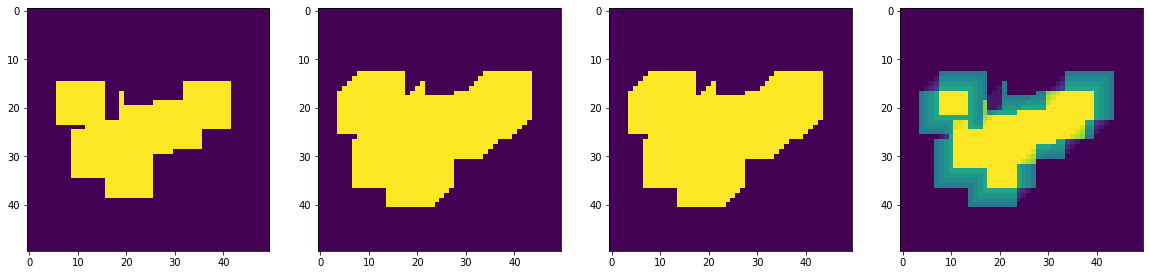

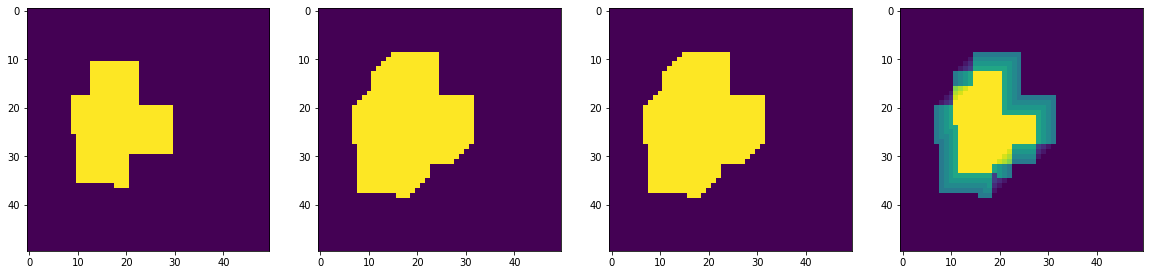

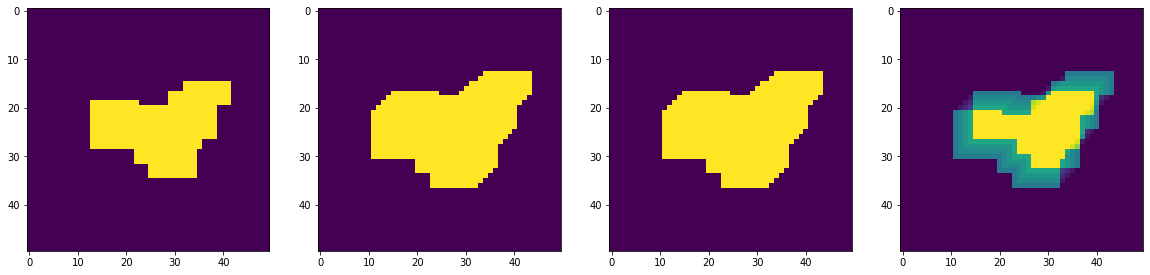

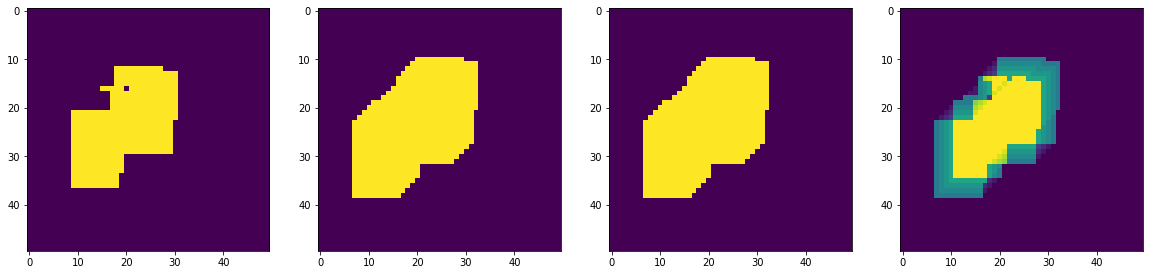

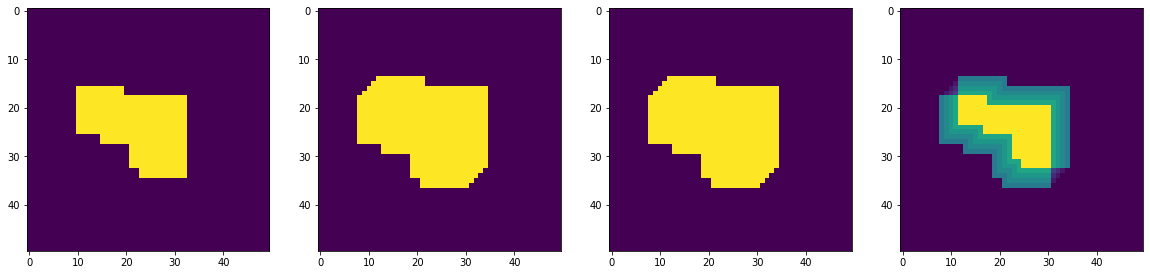

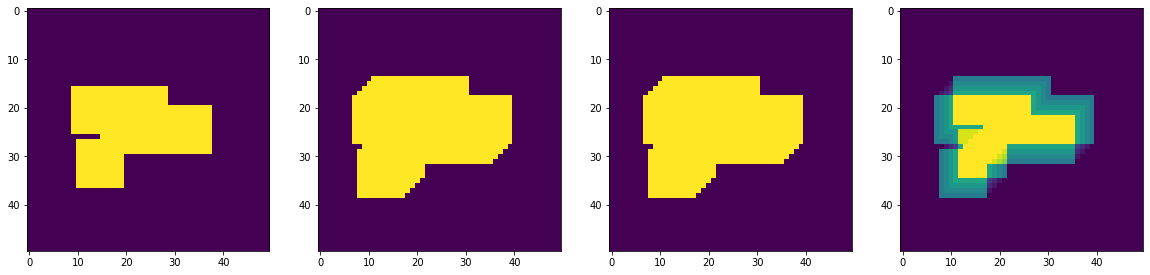

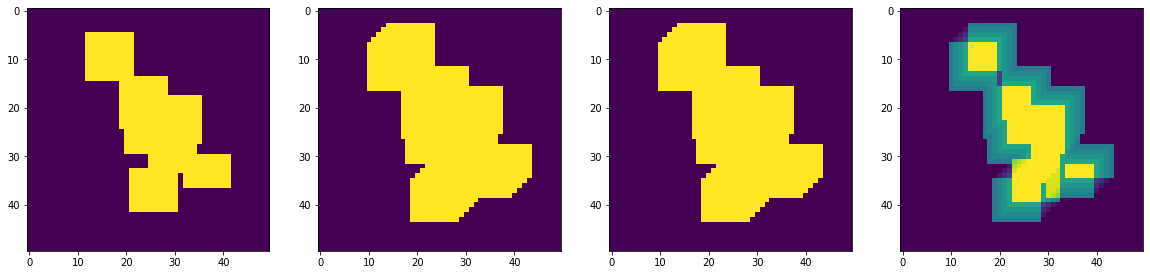

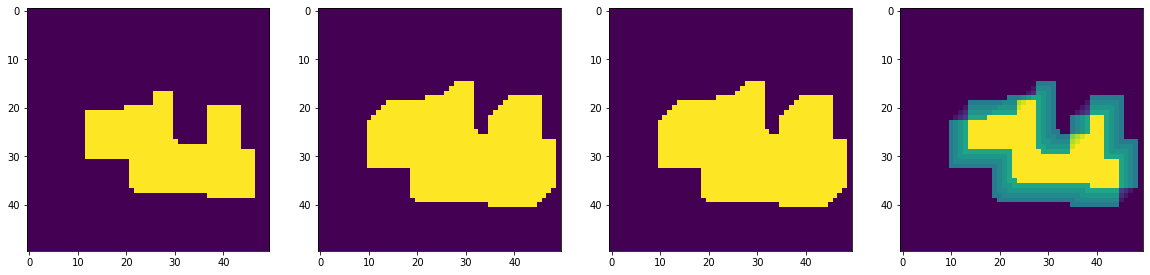

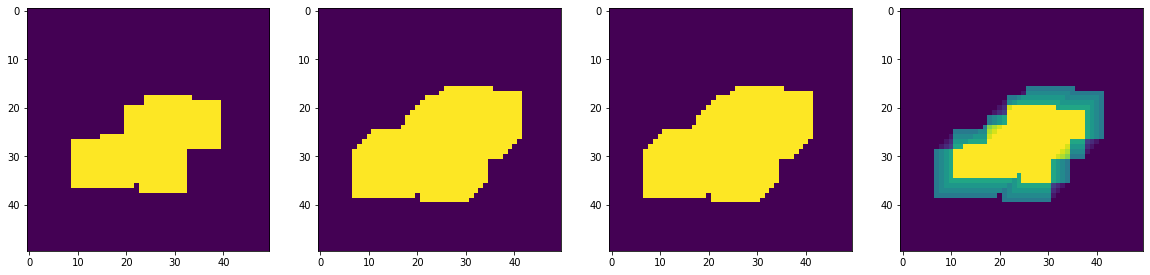

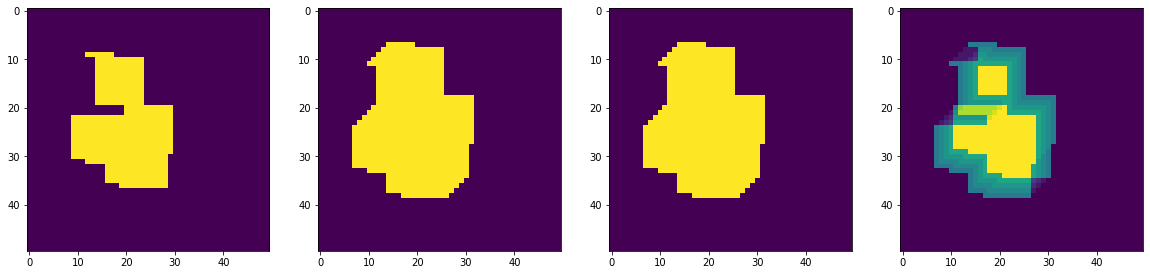

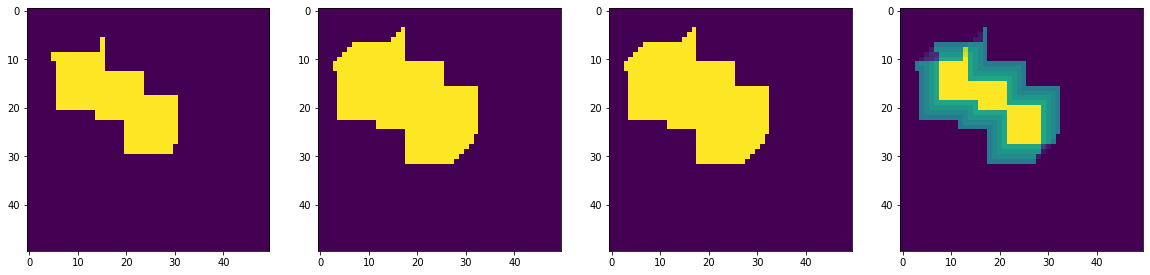

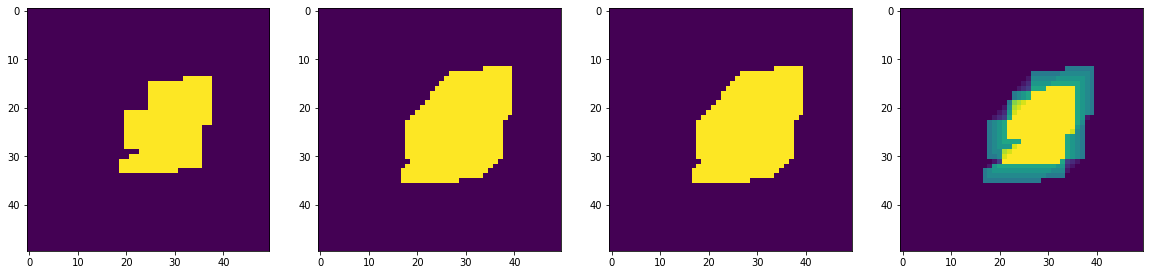

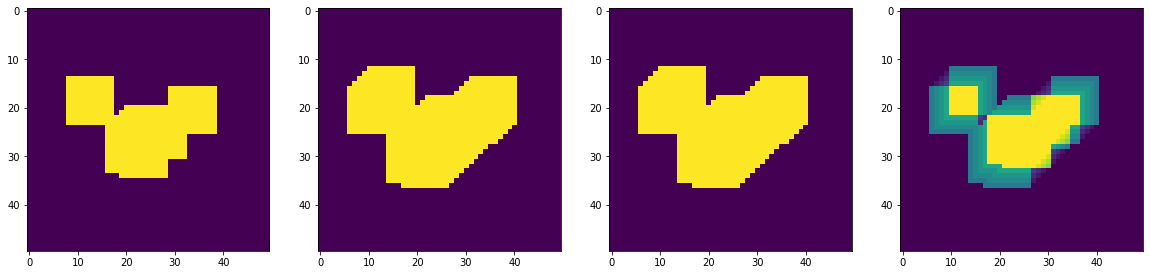

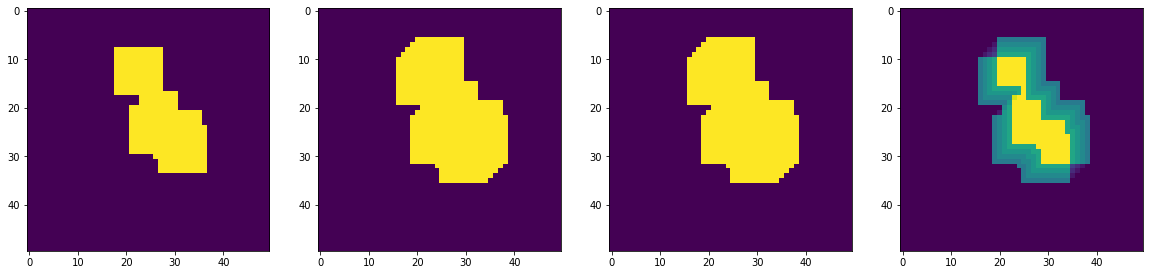

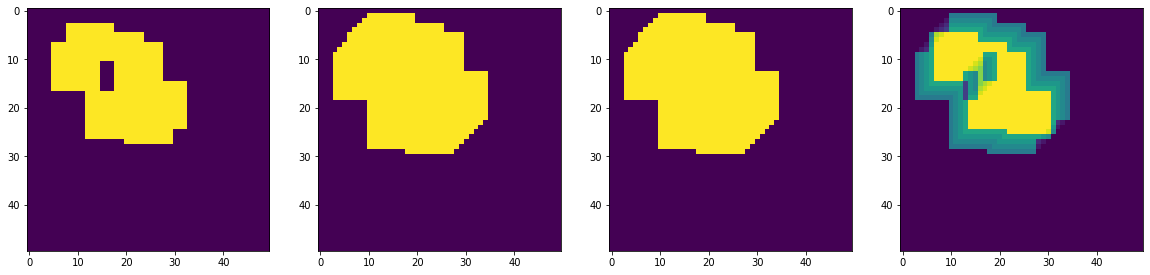

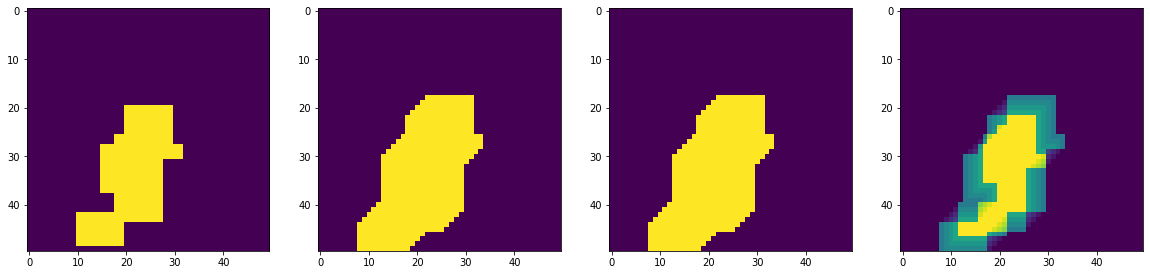

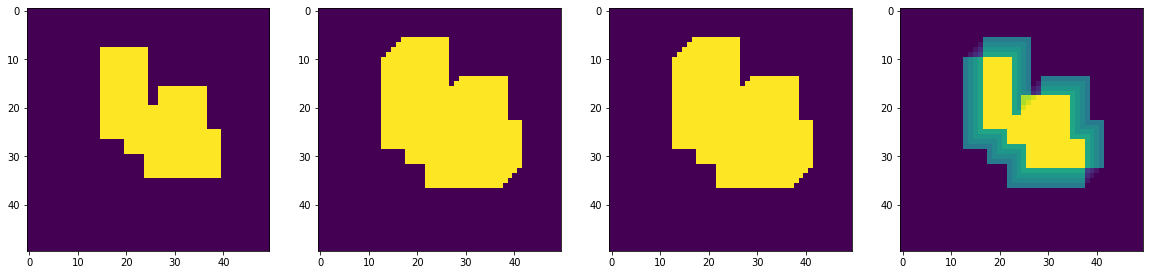

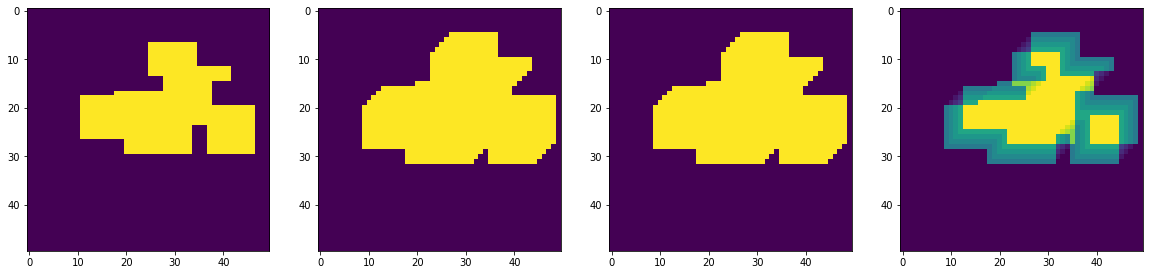

In [113]:
model.to(device)
inputs, targets = next(iter(dataloader))
outputs = model(inputs)
for idx in range(len(inputs)):
    plot_horizontal([tensor[idx].squeeze().cpu().detach() for tensor in [
        inputs, targets, outputs > 0.05, outputs]])

In [110]:
print(model.model.conv.weight)
print(model.model._normalized_weight)
print(model.model.P_)

Parameter containing:
tensor([[[[-0.1435, -0.1434, -0.1436, -0.1433,  0.9307],
          [-0.1434, -0.1434, -0.1434,  0.0202, -0.1433],
          [-0.1435, -0.1433,  0.0130, -0.1434, -0.1434],
          [-0.1433,  0.0191, -0.1431, -0.1431, -0.1435],
          [ 0.9319, -0.1432, -0.1434, -0.1435, -0.1435]]]], device='cuda:0',
       requires_grad=True)
tensor([[[[1.4809e-05, 5.0633e-05, 0.0000e+00, 8.8175e-05, 4.0749e-01],
          [7.8492e-05, 6.5323e-05, 7.1099e-05, 6.2133e-02, 9.0181e-05],
          [3.1579e-05, 8.9384e-05, 5.9403e-02, 5.0689e-05, 6.7584e-05],
          [8.9418e-05, 6.1683e-02, 1.8620e-04, 1.8275e-04, 8.5349e-06],
          [4.0793e-01, 1.2621e-04, 4.5783e-05, 1.2316e-05, 1.6386e-05]]]],
       device='cuda:0', grad_fn=<DivBackward0>)
Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True)


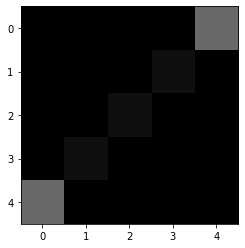

In [109]:
# plt.imshow(torch.sigmoid(model.model.conv.weight).cpu().detach()[0, 0], cmap='gray',
#           vmin=0, vmax=1)
plt.imshow(model.model._normalized_weight.cpu().detach()[0, 0], cmap='gray',
          vmin=0, vmax=1)

## Opening

9.0


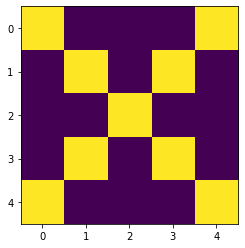

In [16]:
reload_modules()
selem = np.zeros((5, 5))
selem[np.arange(5), 5 - np.arange(1, 6)] = 1
selem[np.arange(5), np.arange(5)] = 1
# selem = morp.disk(2)
plt.imshow(selem)
print(selem.sum())

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=1_000_000, 
    size=(50, 50), 
    n_rectangles=8,
    device=device, 
    max_shape=(10, 10), 
    selem=selem,
    morp_operation="opening",
)

In [17]:
reload_modules()
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

observables = [
    obs.PlotParametersMultipleDilations(1000),
    obs.PlotPreds(),
    obs.WeightsHistogramMultipleDilations(1000)
]

model = lon.LightningOpeningNet(
    model_args={
        "share_weights": True, "in_channels": 1, "out_channels": 1, "kernel_size": (5, 5)
    },
    learning_rate=1e-2,
    loss=loss,
    optimizer=optimizer,
    output_dir="deep_morpho/results",
    observables=observables
)
model.to(device)

logger = TensorBoardLogger("deep_morpho/results", name='Opening')
print(logger.log_dir)

logger.experiment.add_graph(model, torch.ones(1, 1, 50, 50).to(device))
logger.experiment.add_image("target_SE", selem[np.newaxis, :])

trainer = Trainer(
    max_epochs=1,
    gpus=1 if torch.cuda.is_available() else 0,
    logger=logger,
    progress_bar_refresh_rate=10,
    callbacks=observables.copy()
)

trainer.fit(model, dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | OpeningNet        | 56    
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)


deep_morpho/results/Opening/version_0


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/hdd/aouadt/these/projets/3d_segm/general/array_morphology.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(ar).unsqueeze(0).unsqueeze(0).float().to(device)


# BiMoNN

## BiSE

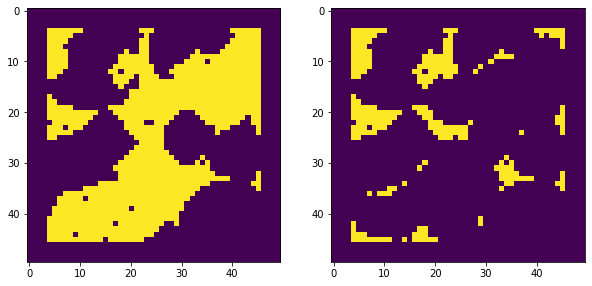

In [5]:
reload_modules()
selem = morp.disk(3)


morp_operation = morpop.ParallelMorpOperations.white_tophat(('disk', 3))

# plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = mrda.InputOutputGeneratorDataset.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={'size': (50, 50), 'n_shapes': 20, 'max_shape': (20, 20), 
                     'p_invert': 0.5, 'n_holes': 10, 'max_shape_holes': (10, 10), 
                     'noise_proba': 0.02},
    device=device,
    morp_operation=morp_operation,
)

img, target = next(iter(dataloader))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(img[0, 0].cpu().detach())

plt.subplot(122)
plt.imshow(target[0, 0].cpu().detach())


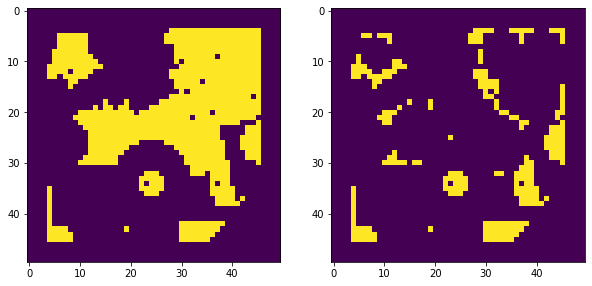

In [6]:
img, target = next(iter(dataloader))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(img[0, 0].cpu().detach())

plt.subplot(122)
plt.imshow(target[0, 0].cpu().detach())


In [47]:
reload_modules()

net = bimonn.BiMoNN(
    kernel_size=[7, 7],
    channels=[1,2,1],
    atomic_element="bisel",
    threshold_mode="tanh",
    constant_activation_P=False,
    constant_weight_P=True,
)
net.to(device);


In [10]:
otp = net(img.cuda())



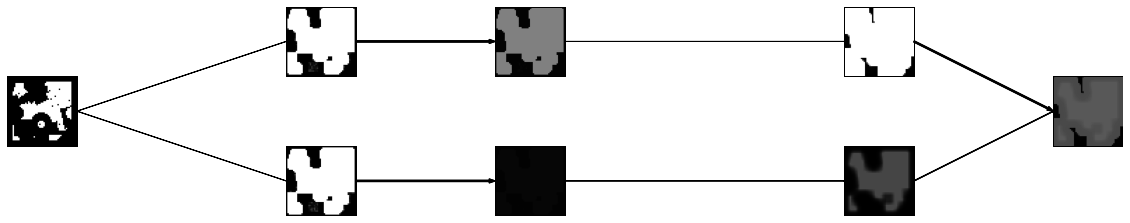

In [48]:
reload_modules()

vizf = bimonn_viz.BimonnForwardVizualiser(model=net, inpt=img.cuda())
vizf.draw(figsize=(20, 10))

In [25]:
otp = net.forward_save(img.cuda())

In [21]:
otp[0].keys()

dict_keys([0, (0, 0), 'output'])

In [11]:
new_weight = net.layer2.lui_0.weight + 0
new_weight[0, 0] = 100
net.layer2.lui_0.set_param_from_weights(new_weight)

tensor([[100.0000,   0.1165]], device='cuda:0', grad_fn=<CopySlices>)

In [12]:
botp2= net(img.cuda())

In [21]:
net.layer1.lui_0.bias

Parameter containing:
tensor([0.2642], device='cuda:0', requires_grad=True)

In [17]:
it1 = net.layer1(img.cuda())
it2 = net.layer2.bise_0(it1)

In [20]:
it1.unique()

tensor([0.7010, 0.7010, 0.7010, 0.7010, 0.7010, 0.7010, 0.7010, 0.7011, 0.7013,
        0.7019, 0.7019, 0.7049, 0.7049, 0.7049, 0.7106, 0.7106, 0.7106, 0.7106,
        0.7106, 0.7106, 0.7354, 0.7354, 0.7354, 0.7354, 0.7354, 0.7354, 0.7354,
        0.7660, 0.7660, 0.7660, 0.7660, 0.7660, 0.7660, 0.7660, 0.7660, 0.7660,
        0.8173, 0.8173, 0.8173, 0.8173, 0.8173, 0.8173, 0.8173, 0.8173, 0.8173,
        0.8173, 0.8173, 0.8173, 0.8173, 0.8173, 0.8364, 0.8364, 0.8364, 0.8364,
        0.8364, 0.8364, 0.8364, 0.8364, 0.8364, 0.8364, 0.8483, 0.8483, 0.8483,
        0.8508, 0.8508, 0.8508, 0.8520, 0.8522, 0.8523, 0.8524, 0.8524, 0.8524,
        0.8524, 0.8524, 0.8524, 0.8524], device='cuda:0',
       grad_fn=<Unique2Backward>)

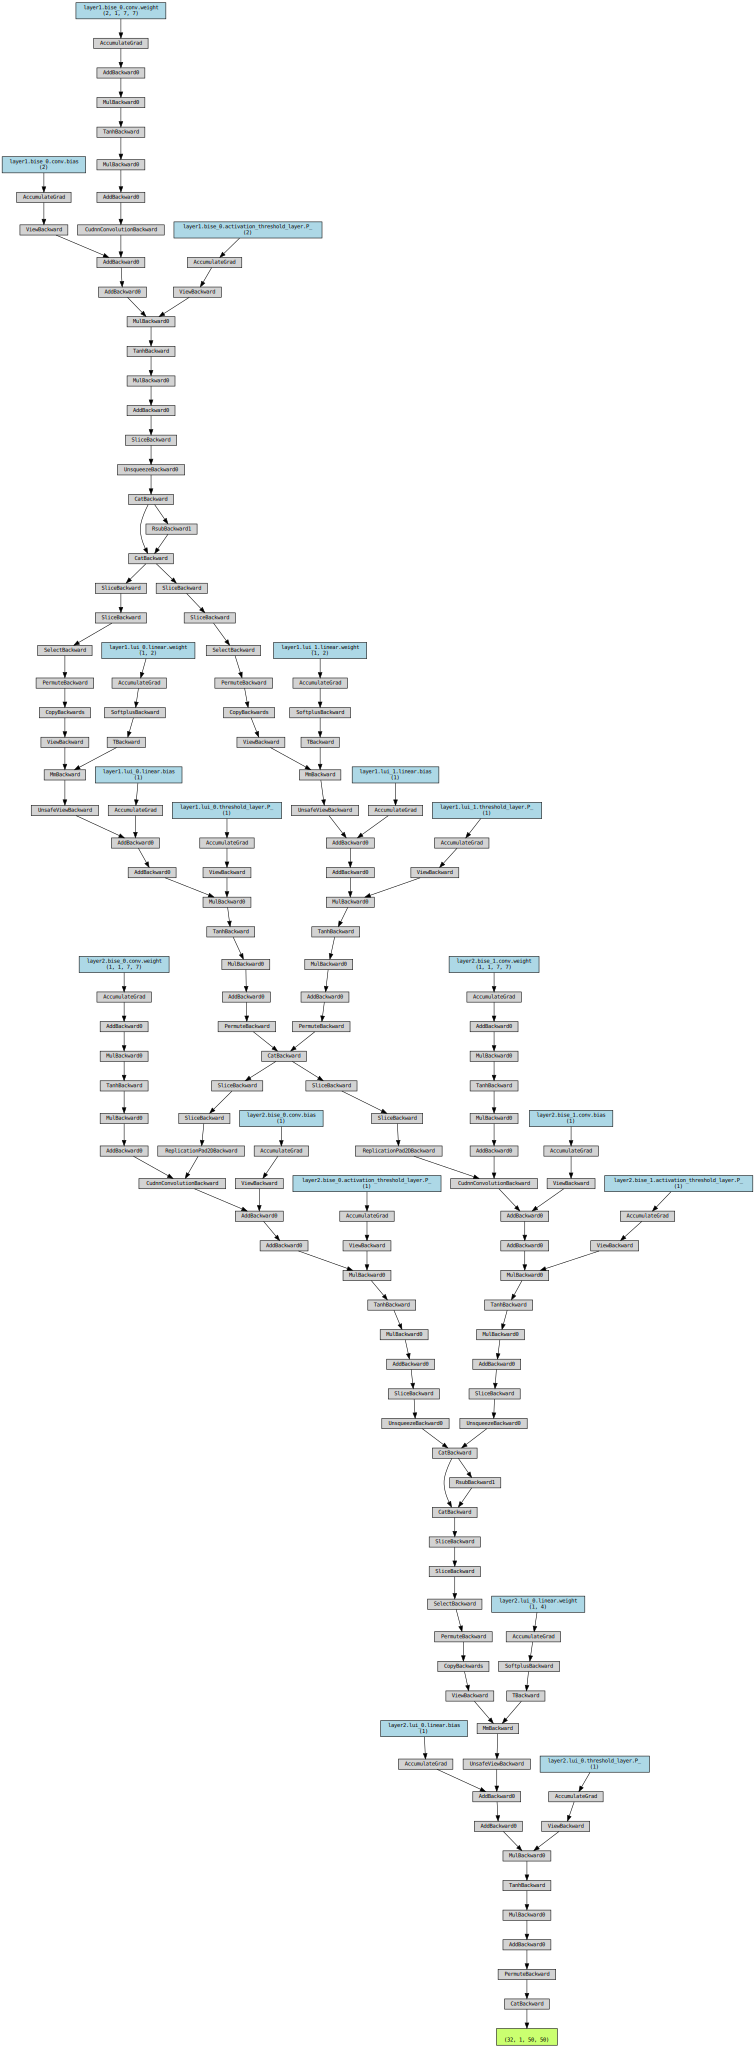

In [8]:
torchviz.make_dot(otp, params=dict(net.named_parameters()))

In [21]:
net.layer1(img.cuda()).unique()

tensor([0.8357, 0.8357], device='cuda:0', grad_fn=<Unique2Backward>)

In [22]:
layer = net.layer1

In [23]:

layer

BiSEL(
  (bise_0): BiSE(
    (conv): Conv2d(1, 2, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=replicate)
    (weight_threshold_layer): TanhLayer()
    (activation_threshold_layer): TanhLayer()
  )
  (lui_0): LUI(
    (threshold_layer): TanhLayer()
    (linear): Linear(in_features=2, out_features=1, bias=True)
    (softplus_layer): Softplus(beta=1, threshold=20)
  )
  (lui_1): LUI(
    (threshold_layer): TanhLayer()
    (linear): Linear(in_features=2, out_features=1, bias=True)
    (softplus_layer): Softplus(beta=1, threshold=20)
  )
)

In [17]:
reload_modules()
net = bisel.BiSEL(
    kernel_size=7,
    in_channels=1,
    out_channels=2,
    threshold_mode='tanh'
)

In [67]:
bise_res = net.bise_0(img)
lui_inpt1 = torch.cat([bise_res, 1-bise_res], axis=1)

In [19]:
otp = net(img)

In [26]:
i1 = torch.tensor([2.])[None, None, None, :]
i2 = torch.tensor([1.])[None, None, None, :]

lin = nn.Linear(2, 1, bias=0)
lin.weight.data = torch.FloatTensor([[1, 2]])

inp = torch.cat([i1, i2], axis=-1)

lin(inp)

tensor([[[[4.]]]], grad_fn=<UnsafeViewBackward>)

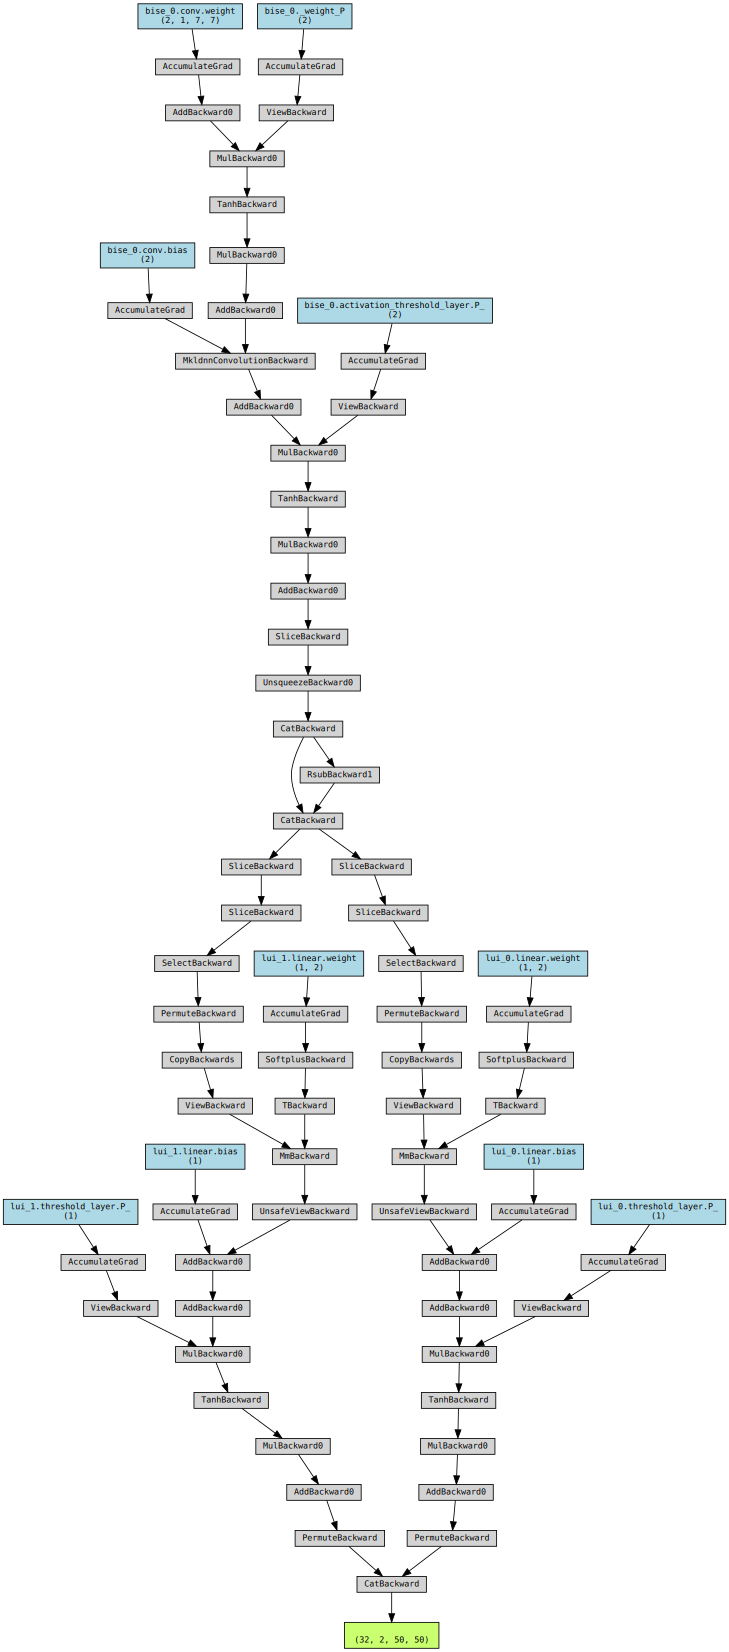

In [8]:
torchviz.make_dot(otp, params=dict(net.named_parameters()))

In [43]:
net.luis[0].positive_weight

tensor([[1.3133, 1.3133]], grad_fn=<SoftplusBackward>)

## Max PLus

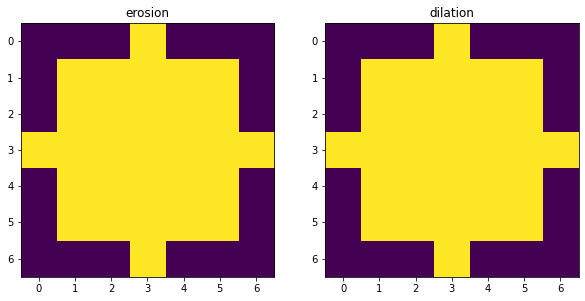

In [7]:
reload_modules()

morp_operation = arm.SequentialMorpOperations(
    name="opening", 
    selems=[morp.disk(3), morp.disk(3)],
    operations=['erosion', 'dilation'],
    device=device
)

plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = mrda.MultiRectDatasetGenerator.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5,
                    'border': (4, 4)},
    device=device,
    morp_operation=morp_operation,
)



In [18]:
img, target = next(iter(dataloader))
img = img.to('cpu')

/hdd/aouadt/these/projets/3d_segm/general/array_morphology.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(ar).unsqueeze(0).unsqueeze(0).float().to(device)


In [19]:
%%time
reload_modules()
net = bimonn.BiMoNN(kernel_size=[(7, 7)], atomic_element='max_plus', threshold_mode='tanh')
net.to('cpu')

CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 13.4 ms


BiMoNN(
  (layer1): MaxPlusAtom(
    (dilation_sum_layer): DilationSumLayer(
      (unfolder): Unfolder()
      (maxpool): MaxPool2d(kernel_size=(7, 7), stride=(7, 7), padding=0, dilation=1, ceil_mode=False)
      (activation_threshold_layer): TanhLayer()
    )
    (complementation_layer): ComplementationLayer(
      (threshold_layer): TanhLayer()
    )
  )
)

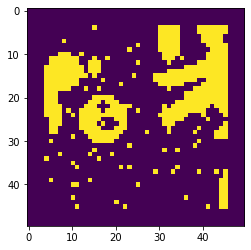

In [25]:
plt.imshow(img[0, 0])

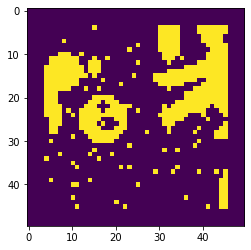

In [24]:
plt.imshow(net.layers[0].dilation_sum_layer(img)[0, 0].detach())

In [28]:
otp = net(img)
print(img - otp)

tensor([[[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          ...,
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000]]],


        [[[-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
          [-0.5000, -0.500

In [25]:
net.layers[0].weight

Parameter containing:
tensor([[-10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10.,   0., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10., -10., -10.]], device='cuda:0',
       requires_grad=True)

## COBiSE

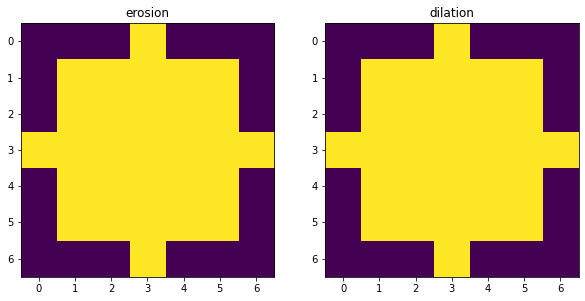

In [36]:
reload_modules()

morp_operation = arm.SequentialMorpOperations(
    name="opening", 
    selems=[morp.disk(3), morp.disk(3)],
    operations=['erosion', 'dilation'],
    device=device
)

plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5,
                    'border': (4, 4)},
    device=device,
    morp_operation=morp_operation,
)



In [66]:
reload_modules()
net = bimonn.BiMoNN(kernel_size=[(7, 7)], atomic_element='cobisec')
net.to(device)

BiMoNN(
  (layer1): COBiSEC(
    (dilations1): BiSEC(
      (conv): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False, padding_mode=replicate)
      (weight_threshold_layer): TanhLayer()
      (activation_threshold_layer): TanhLayer()
      (complementation_layer): ComplementationLayer(
        (threshold_layer): TanhLayer()
      )
    )
    (dilations2): BiSEC(
      (conv): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False, padding_mode=replicate)
      (weight_threshold_layer): TanhLayer()
      (activation_threshold_layer): TanhLayer()
      (complementation_layer): ComplementationLayer(
        (threshold_layer): TanhLayer()
      )
    )
  )
)

In [76]:
net.layers[0].dilations1.alpha.requires_grad = False
net.layers[0].dilations1.alpha.fill_(4)

Parameter containing:
tensor([4.], device='cuda:0')

In [77]:
print(net.layers[0].dilations1.weight)
print(net.layers[0].dilations2.weight)

Parameter containing:
tensor([[[[-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1.,  1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.]]]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[[[-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1.,  1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1.]]]], device='cuda:0',
       requires_grad=True)


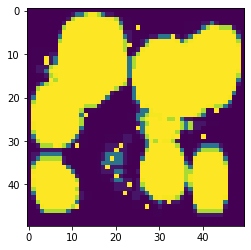

In [82]:
plt.imshow(net.layers[0].dilations1(img)[0, 0].cpu().detach())

In [78]:
plt.imshow(net(img)[0, 0].cpu().detach())

In [79]:
plt.imshow(img[0, 0].cpu().detach())

In [53]:
isinstance(net.layers[0].dilations1.thresholded_alpha, nn.Parameter)

False

In [59]:
class A:
    def __init__(self):
        self._a = 1
    @property
    def a(self):
        return {'a': self._a}

class B:
    def __init__(self, a):
        self.a = a

a = A()
b = B(a.a)

a._a = 2
print(b.a)

{'a': 1}


# LogicalNotBise

## Loss for opening

<IPython.core.display.Javascript object>


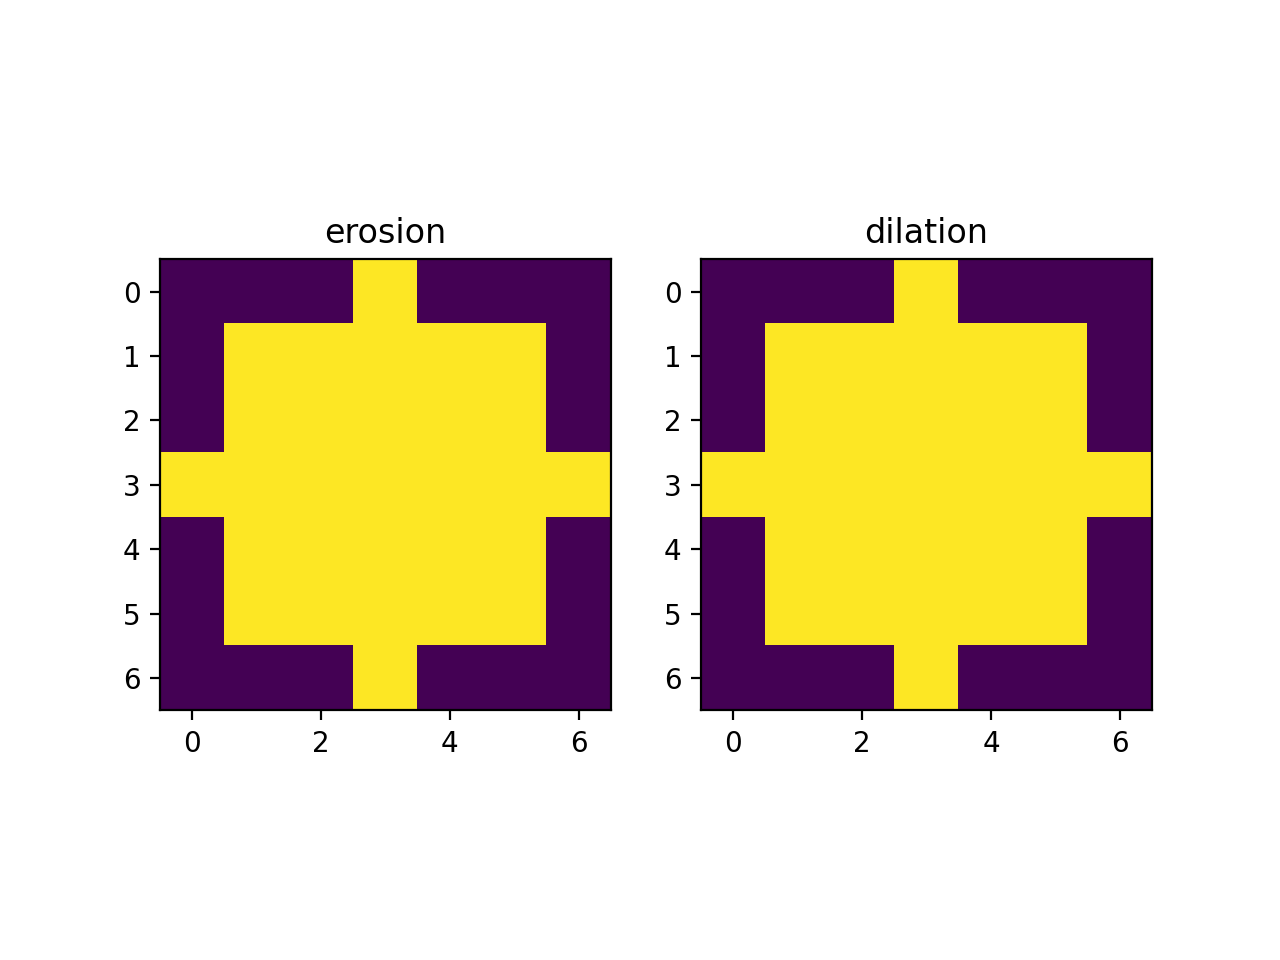

/hdd/aouadt/these/projets/3d_segm/general/array_morphology.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(ar).unsqueeze(0).unsqueeze(0).float().to(device)


In [159]:
reload_modules()

morp_operation = arm.SequentialMorpOperations(
    operations=['erosion', 'dilation'],
    selems=[selm.disk(3), selm.disk(3)],
    device=device,
    name="opening"
)

fig = plt.figure()
for selem_idx, selem in enumerate(morp_operation.selems):
    ax = fig.add_subplot(1, len(morp_operation), selem_idx + 1)
    ax.imshow(selem)
    ax.set_title(morp_operation.operations[selem_idx])

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5},
    device=device, 
    selem=selem,
    morp_operation=morp_operation.morp_fn,
)

img, target = next(iter(dataloader))
img.requires_grad = False
target.requires_grad = False

In [161]:
%%time

reload_modules()
alphas = np.linspace(-5, 5, 100)
loss_values2 = []
loss = nn.BCELoss()
# for idx1, alpha1 in tqdm(enumerate(alphas)):

loss_values = np.zeros((len(alphas), len(alphas)))
with torch.no_grad():
    for idx1, alpha1 in tqdm(enumerate(alphas)):
    # for alpha1 in [-10]:
        for idx2, alpha2 in enumerate(alphas):
    #     for alpha2 in [-10]:
            net_dil = bimonn.BiMoNN(
                kernel_size=[(7, 7), (7, 7)], 
                logical_not=True, 
                activation_P=[20, 20], 
                alpha_init=[alpha1, alpha2],
#                 threshold_mode={"activation": "tanh", "weight": "tanh", "logical_not": "clamp"}
                threshold_mode="tanh"
            )
            for layer in net_dil.bises:
                layer.conv.weight.data = torch.FloatTensor(
                    morp_operation.selems[0].astype(float) * 10 - 5
                ).unsqueeze(0).unsqueeze(0)
            net_dil.to(device)

            with torch.no_grad():
    #             loss_values2.append(loss(net_dil(img).squeeze(), target).detach().item())
                loss_values[idx1, idx2] = loss(net_dil(img).squeeze(), target).detach().item()

100it [00:22,  4.38it/s]

CPU times: user 22.8 s, sys: 0 ns, total: 22.8 s
Wall time: 22.9 s


<IPython.core.display.Javascript object>


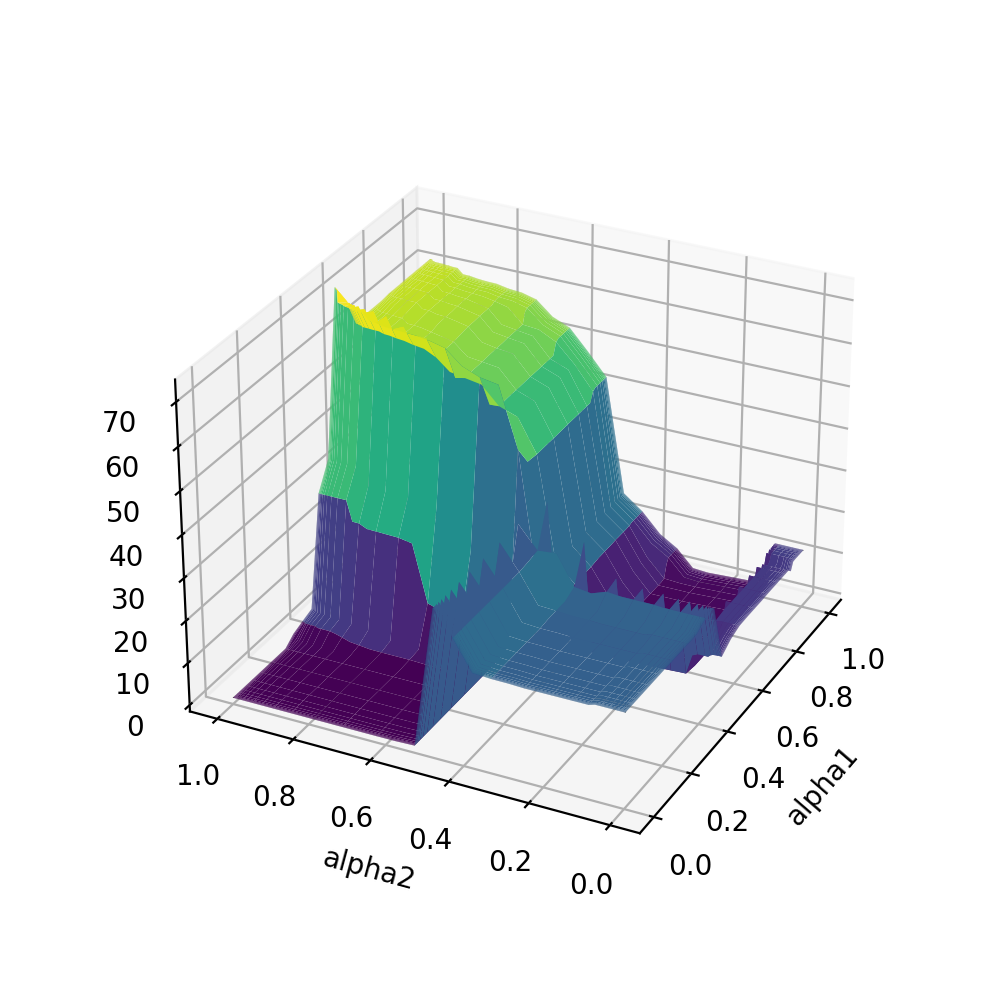

Text(0.5, 0, 'alpha2')

In [165]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(5, 5))

ax = plt.axes(projection='3d')

XX, YY = np.meshgrid(
    net_dil.bises[0].logical_not_layer.threshold_layer(torch.tensor(alphas)), 
    net_dil.bises[0].logical_not_layer.threshold_layer(torch.tensor(alphas)), 
#     alphas,
#     alphas
)
ax.plot_surface(YY, XX, loss_values, 
                cmap='viridis', edgecolor='none')
ax.set_xlabel("alpha1")
ax.set_ylabel("alpha2")

In [125]:
reload_modules()
net = bimonn.BiMoNN(
    kernel_size=[7, 7],
    logical_not=True,
    activation_P=20,
    alpha_init=[0, 1],
    threshold_mode={"activation": "tanh", "weight": "tanh", "logical_not": "clamp"},
)

for layer in net.bises:
    layer.conv.weight.data = torch.FloatTensor(
        morp_operation.selems[0].astype(float) * 10 - 5
    ).unsqueeze(0).unsqueeze(0)
    layer.conv.weight.data *= 5
net.to(device)

BiMoNN(
  (layer1): LogicalNotBiSE(
    (conv): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (weight_threshold_layer): TanhLayer()
    (activation_threshold_layer): TanhLayer()
    (logical_not_layer): LogicalNotLayer(
      (threshold_layer): ClampLayer()
    )
  )
  (layer2): LogicalNotBiSE(
    (conv): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (weight_threshold_layer): TanhLayer()
    (activation_threshold_layer): TanhLayer()
    (logical_not_layer): LogicalNotLayer(
      (threshold_layer): ClampLayer()
    )
  )
)

In [117]:
net.bises[0]._normalized_weight

tensor([[[[0., 0., 0., 1., 0., 0., 0.],
          [0., 1., 1., 1., 1., 1., 0.],
          [0., 1., 1., 1., 1., 1., 0.],
          [1., 1., 1., 1., 1., 1., 1.],
          [0., 1., 1., 1., 1., 1., 0.],
          [0., 1., 1., 1., 1., 1., 0.],
          [0., 0., 0., 1., 0., 0., 0.]]]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [118]:
def alpha_to(model, bise_idx, alpha_value):
    model.bises[bise_idx].logical_not_layer.alpha.requires_grad = False
    model.bises[bise_idx].logical_not_layer.alpha.fill_(alpha_value)


In [119]:
inter1.max()

tensor(0.9000, device='cuda:0')

inter1 in  0.0 1.0
inter2 in  0.0 1.0


<IPython.core.display.Javascript object>


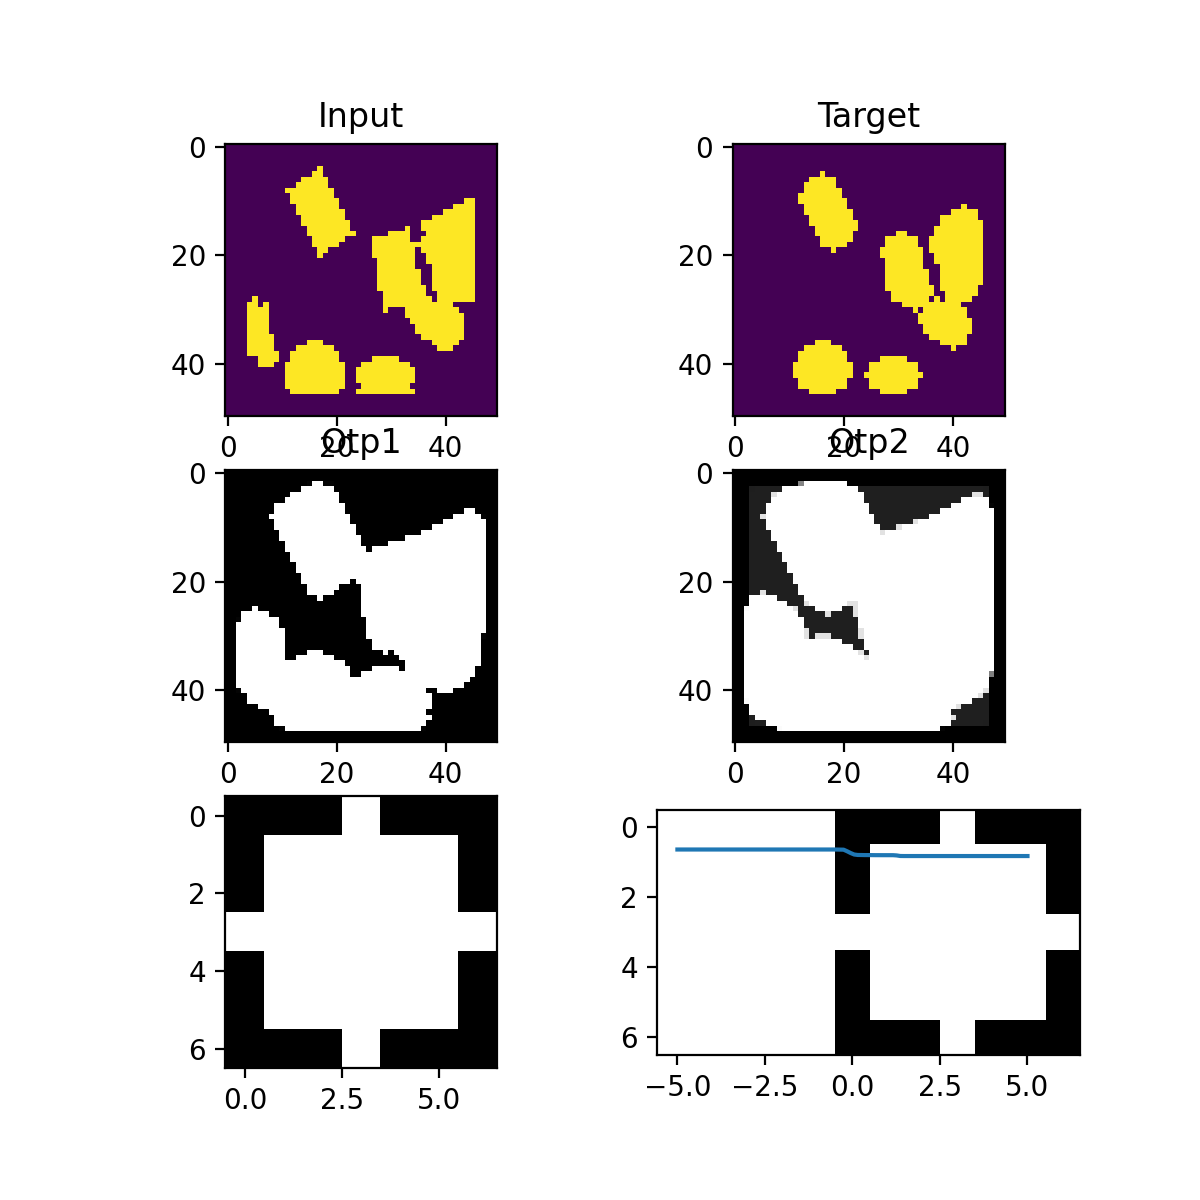

5

In [128]:
alpha_to(net, 0, 0.7)
alpha_to(net, 1, 0.55)

with torch.no_grad():
    inter1 = net.bises[0](img).detach()
    inter2 = net.bises[1](inter1).detach()

print("inter1 in ", inter1.min().item(), inter1.max().item())
print("inter2 in ", inter2.min().item(), inter2.max().item())
    
fig, ax = plt.subplots(3, 2, figsize=(6, 6))

ax[0, 0].imshow(img[0, 0].cpu())
ax[0, 1].imshow(target[0].cpu())
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Target")

ax[1, 0].imshow(inter1[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
ax[1, 1].imshow(inter2[0, 0].cpu(), vmin=0, vmax=1, cmap='gray')
ax[1, 0].set_title("Otp1")
ax[1, 1].set_title("Otp2")

ax[2, 0].imshow(net.bises[0]._normalized_weight.squeeze().detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[2, 1].imshow(net.bises[1]._normalized_weight.squeeze().detach().cpu(), vmin=0, vmax=1, cmap="gray")
5

## Loss for erosion

In [80]:
reload_modules()

morp_operation = arm.SequentialMorpOperations(
    operations=['erosion'],
    selems=[selm.disk(2)],
    device=device,
    name="opening"
)

fig = plt.figure()
for selem_idx, selem in enumerate(morp_operation.selems):
    ax = fig.add_subplot(1, len(morp_operation), selem_idx + 1)
    ax.imshow(selem)
    ax.set_title(morp_operation.operations[selem_idx])

dataloader = mrda.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5},
    device=device, 
    selem=selem,
    morp_operation=morp_operation.morp_fn,
)

img, target = next(iter(dataloader))
for _ in range(10):
    im2, target2 = next(iter(dataloader))
    img = torch.cat((img, im2))
    target = torch.cat((target, target2))
img.requires_grad = False
target.requires_grad = False

print(img.shape)

<IPython.core.display.Javascript object>

torch.Size([352, 1, 50, 50])


In [81]:
%%time

reload_modules()
alphas = np.linspace(-5, 5, 100)
loss = nn.BCELoss()

grad_values = np.zeros((len(alphas)))
loss_values = np.zeros((len(alphas)))
for idx1, alpha1 in tqdm(enumerate(alphas)):
    net_dil = bimonn.BiMoNN(
        kernel_size=[(5, 5)], 
        logical_not=True, 
        activation_P=[10], 
        alpha_init=[alpha1],
#                 threshold_mode={"activation": "tanh", "weight": "tanh", "logical_not": "clamp"}
        threshold_mode="tanh"
    )
    for layer in net_dil.bises:
        layer.conv.weight.data *= -5
#         layer.conv.weight.data = torch.FloatTensor(
#             morp_operation.selems[0].astype(float) * 10 - 5
#         ).unsqueeze(0).unsqueeze(0)
    net_dil.to(device)

    loss_v = loss(net_dil(img).squeeze(), target)
    loss_v.backward()
    grad_values[idx1] = net_dil.bises[0].alpha.grad
    loss_values[idx1] = loss_v.detach().item()

100it [00:00, 204.64it/s]

CPU times: user 499 ms, sys: 0 ns, total: 499 ms
Wall time: 498 ms


<IPython.core.display.Javascript object>


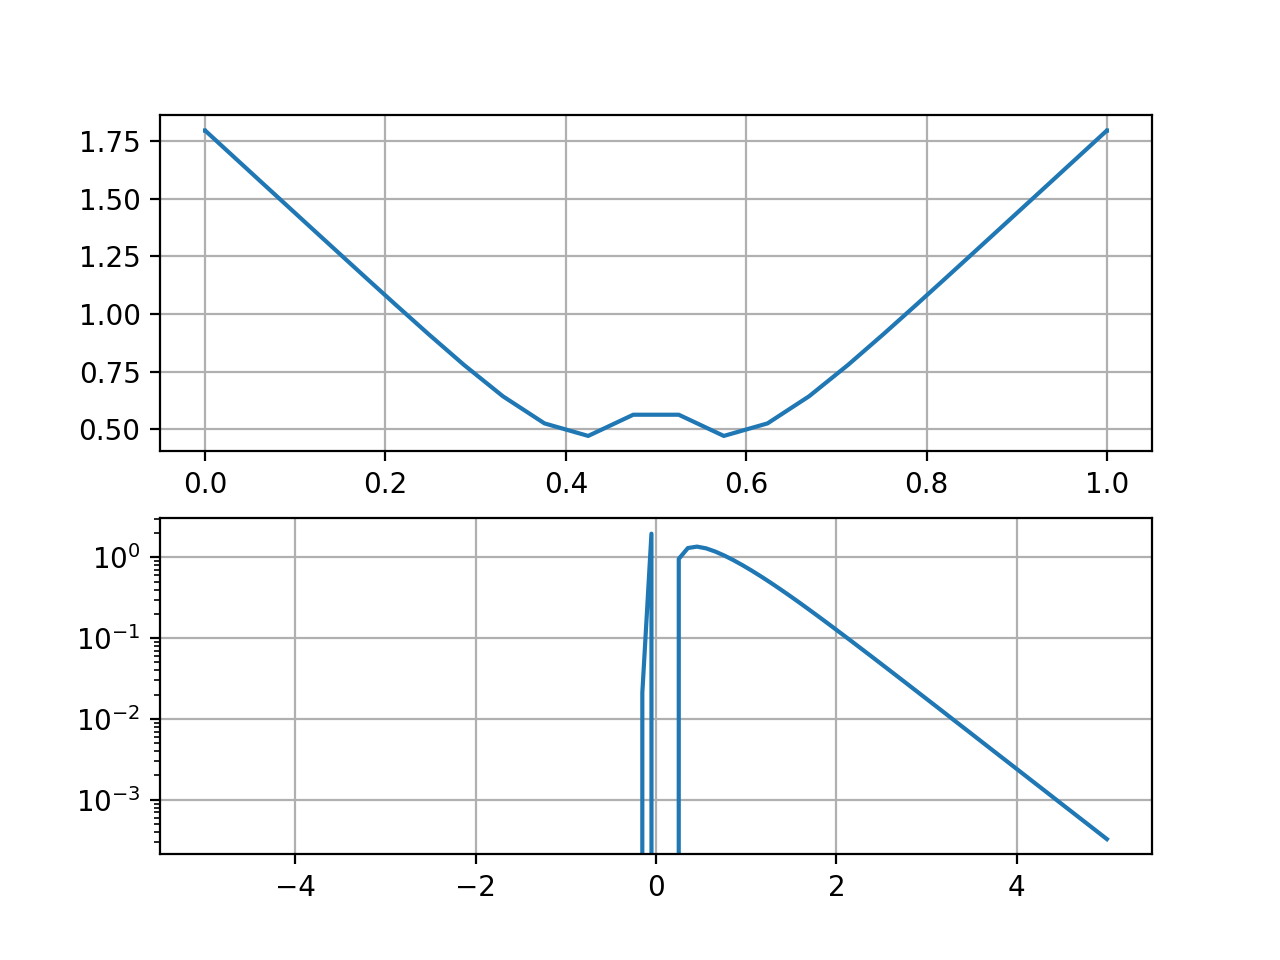

In [83]:
fig = plt.figure()

ax = fig.add_subplot(211)
ax.plot(
    net_dil.bises[0].logical_not_layer.threshold_layer(torch.tensor(alphas)), 
#     alphas,
    loss_values
)
ax.grid()
# ax.set_yscale('log')

ax = fig.add_subplot(212)
ax.plot(
    alphas, 
#     net_dil.bises[0].logical_not_layer.threshold_layer(torch.tensor(alphas)), 
    grad_values,
)
ax.set_yscale('log')
ax.grid()

In [58]:
net_dil.bises[0].conv.padding_mode

'zeros'

# BiMoNN Init

## Segmentation

In [71]:
reload_modules()

morp_operation = morpop.ParallelMorpOperations.black_tophat(('dcross', 7))

# plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = mrda.InputOutputGeneratorDataset.get_loader(
    batch_size=256, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={'size': (50, 50), 'n_shapes': 20, 'max_shape': (20, 20), 
                     'p_invert': 0, 'n_holes': 10, 'max_shape_holes': (10, 10), 
                     'noise_proba': 0.02, "border": (0, 0)},
    device=device,
    morp_operation=morp_operation,
    do_symetric_output=True,
)

img, target = next(iter(dataloader))
img.mean()



tensor(-0.0919)

In [72]:
%%time
reload_modules()
model = bimonn.BiMoNN(
    kernel_size=[7, 7, 7, 7, 7, 7, 7, 7],
    channels=[1,2, 2, 2, 2, 2, 2, 2, 1],
    # kernel_size=[7, 7],
    # channels=[1, 1, 1],
    # channels=[1,3, 3, 3, 1],
    init_weight_mode=inits.InitBiseEnum.CUSTOM_HEURISTIC,
    activation_P=.5,
    initializer_method=inits.InitBimonnEnum.INPUT_MEAN,
    initializer_args={
            # "bise_init_method": InitBiseEnum.CUSTOM_CONSTANT,
            # "bise_init_method": inits.InitBiseEnum.CUSTOM_HEURISTIC_RANDOM_BIAS,
            "bise_init_method": inits.InitBiseEnum.CUSTOM_CONSTANT_RANDOM_BIAS,
            "bise_init_args": {"init_bias_value": 0, "mean_weight": "auto", "ub": 0.01, },
            "input_mean": 0
        },
    bias_optim_mode=bise_base.BiseBiasOptimEnum.RAW,
    bias_optim_args={"offset": 0},
    weights_optim_mode=bise_base.BiseWeightsOptimEnum.THRESHOLDED,
    weights_optim_args={"constant_P": True, "factor": 1},
)
model.cuda()
pass


CPU times: user 737 ms, sys: 15.7 ms, total: 753 ms
Wall time: 751 ms


(array([ 5.,  3.,  3.,  6.,  2.,  7.,  2., 10.,  8.,  3.]),
 array([0.25631887, 0.3043137 , 0.35230854, 0.40030336, 0.44829822,
        0.49629304, 0.54428786, 0.5922827 , 0.64027756, 0.68827236,
        0.7362672 ], dtype=float32),
 <BarContainer object of 10 artists>)

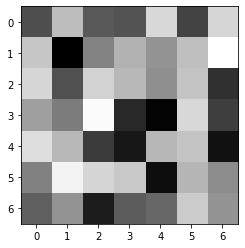

In [24]:
weights = model.layer1.bise_0._normalized_weight.cpu().detach().squeeze().numpy()
plt.imshow(weights, cmap='gray')
plt.figure()
plt.hist(weights.flatten())

In [73]:
fig, axs = plt.subplots(1, img.shape[1], figsize=(5*img.shape[1], 5), squeeze=False)
for chan in range(img.shape[1]):
    axs[0, chan].hist(model.layers[0].bises[0]._normalized_weights[chan][0].cpu().detach().view(-1).numpy())
    axs[0, chan].set_title(model.layers[0].bises[0].bias[chan].item())
    axs[0, chan].grid(True)

In [74]:
# reload_modules()
viz_hist = bimonn_viz.BimonnHistogramVizualiser(model=model, inpt=img.cuda(), dpi=300);
viz_hist.draw(figsize=(20, 10), dpi=300)


In [75]:
vizf = bimonn_viz.BimonnForwardVizualiser(model=model, inpt=img.cuda())
vizf.draw(figsize=(20, 10))

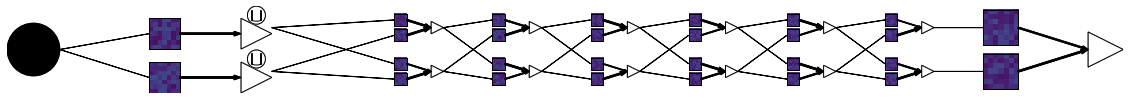

In [76]:
bimonn_viz.BimonnVizualiser(model).draw(figsize=(20, 10))


## Classification

In [29]:
reload_modules()


# plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = MnistClassifDataset.get_loader(
    n_inputs=1000,
    train=True,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    threshold=30,
    invert_input_proba=0,
)

img, target = next(iter(dataloader))
img.mean()



tensor(0.1756)

In [40]:
img = (torch.randint(0, 2, (256, 1, 28, 28))).float()

In [54]:
%%time
reload_modules()
model2 = bimonn.BiMoNNClassifier(
    kernel_size=[3, 3],
    channels=[1, 6, 1],
    n_classes=10,
    input_size=28,
    init_weight_mode=bise.InitBiseEnum.CUSTOM_CONSTANT,
    # channels=[1,3, 3, 3, 1],
    activation_P=1,
    # init_bias_value=img.mean(),
    init_bias_value_bise="auto",
    init_bias_value_lui=1.6,
    input_mean=img.mean(),
)
# model2 = LightningBiMoNNClassifier(
#     model_args={
#         "kernel_size":[3, 3],
#         "channels":[1, 6, 1],
#         "n_classes":10,
#         "input_size":28,
#         # "#":channels=[1,3, 3, 3, 1],
#         "activation_P":10,
#         "init_bias_value":img.mean(),
#     }
# )
model2.cuda()
pass


AssertionError: tensor([[[[-0.0464, -0.0471,  0.0117,  ...,  0.0050,  0.0689, -0.0404],
          [ 0.0793, -0.0039, -0.0701,  ...,  0.0622,  0.0727, -0.0303],
          [-0.0125,  0.0551, -0.0101,  ..., -0.0294,  0.0361, -0.0527],
          ...,
          [ 0.0905, -0.0095, -0.0127,  ...,  0.0050,  0.0493,  0.0817],
          [ 0.0514,  0.0792, -0.0501,  ..., -0.0364,  0.0113, -0.0213],
          [ 0.0175,  0.0123, -0.0265,  ...,  0.0770,  0.0224, -0.0798]]],


        [[[-0.0637,  0.0131,  0.0185,  ..., -0.0613, -0.0678, -0.0410],
          [-0.0690,  0.0551, -0.0328,  ...,  0.0438, -0.0255, -0.0595],
          [-0.0509,  0.0382, -0.0078,  ..., -0.0802, -0.0333,  0.0257],
          ...,
          [-0.0599,  0.0831, -0.0493,  ...,  0.0847,  0.0222, -0.0309],
          [ 0.0747, -0.0329,  0.0685,  ..., -0.0632, -0.0129,  0.0668],
          [-0.0567,  0.0410,  0.0913,  ...,  0.0516, -0.0308, -0.0383]]],


        [[[-0.0722,  0.0623, -0.0079,  ...,  0.0421,  0.0171,  0.0158],
          [ 0.0268, -0.0789,  0.0616,  ...,  0.0058, -0.0474,  0.0688],
          [ 0.0193, -0.0250,  0.0772,  ...,  0.0819, -0.0143, -0.0466],
          ...,
          [-0.0059, -0.0403, -0.0242,  ..., -0.0686,  0.0376,  0.0732],
          [ 0.0690, -0.0307,  0.0524,  ..., -0.0520, -0.0144,  0.0292],
          [ 0.0106, -0.0611,  0.0451,  ...,  0.0743, -0.0122,  0.0553]]],


        ...,


        [[[ 0.0836, -0.0576,  0.0097,  ..., -0.0341,  0.0270, -0.0722],
          [-0.0286, -0.0308, -0.0406,  ...,  0.0865, -0.0157,  0.0465],
          [ 0.0715, -0.0070,  0.0676,  ...,  0.0451,  0.0746,  0.0283],
          ...,
          [ 0.0888, -0.0200,  0.0005,  ...,  0.0014, -0.0137, -0.0532],
          [-0.0820,  0.0122,  0.0480,  ...,  0.0314, -0.0709,  0.0500],
          [ 0.0628,  0.0772,  0.0160,  ..., -0.0163,  0.0245,  0.0870]]],


        [[[ 0.0784,  0.0611,  0.0604,  ..., -0.0614,  0.0085,  0.0283],
          [-0.0715,  0.0475, -0.0123,  ...,  0.0298,  0.0292, -0.0750],
          [ 0.0445, -0.0217, -0.0608,  ...,  0.0325, -0.0334,  0.0624],
          ...,
          [ 0.0042, -0.0113, -0.0027,  ...,  0.0676,  0.0562,  0.0497],
          [-0.0617,  0.0690, -0.0738,  ..., -0.0766, -0.0251, -0.0359],
          [ 0.0113,  0.0449, -0.0090,  ..., -0.0272,  0.0635, -0.0538]]],


        [[[-0.0266, -0.0196,  0.0241,  ..., -0.0685, -0.0785,  0.0324],
          [-0.0695, -0.0405, -0.0423,  ..., -0.0372,  0.0403,  0.0337],
          [-0.0696, -0.0082,  0.0376,  ...,  0.0216, -0.0051, -0.0663],
          ...,
          [-0.0193,  0.0541,  0.0685,  ..., -0.0229, -0.0562, -0.0328],
          [-0.0543,  0.0900, -0.0652,  ..., -0.0670, -0.0238, -0.0665],
          [-0.0680, -0.0502, -0.0367,  ..., -0.0617,  0.0514,  0.0087]]]])

In [36]:
model2.input_mean

[tensor(0.4990), 0.5]

In [32]:
curl = model2.layers[-1].bise_0
print(curl.bias)
print(curl._normalized_weight.std())
print(curl._normalized_weight.mean())

tensor([-2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000,
        -2.0000, -2.0000], device='cuda:0', grad_fn=<SubBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<StdBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<MeanBackward0>)


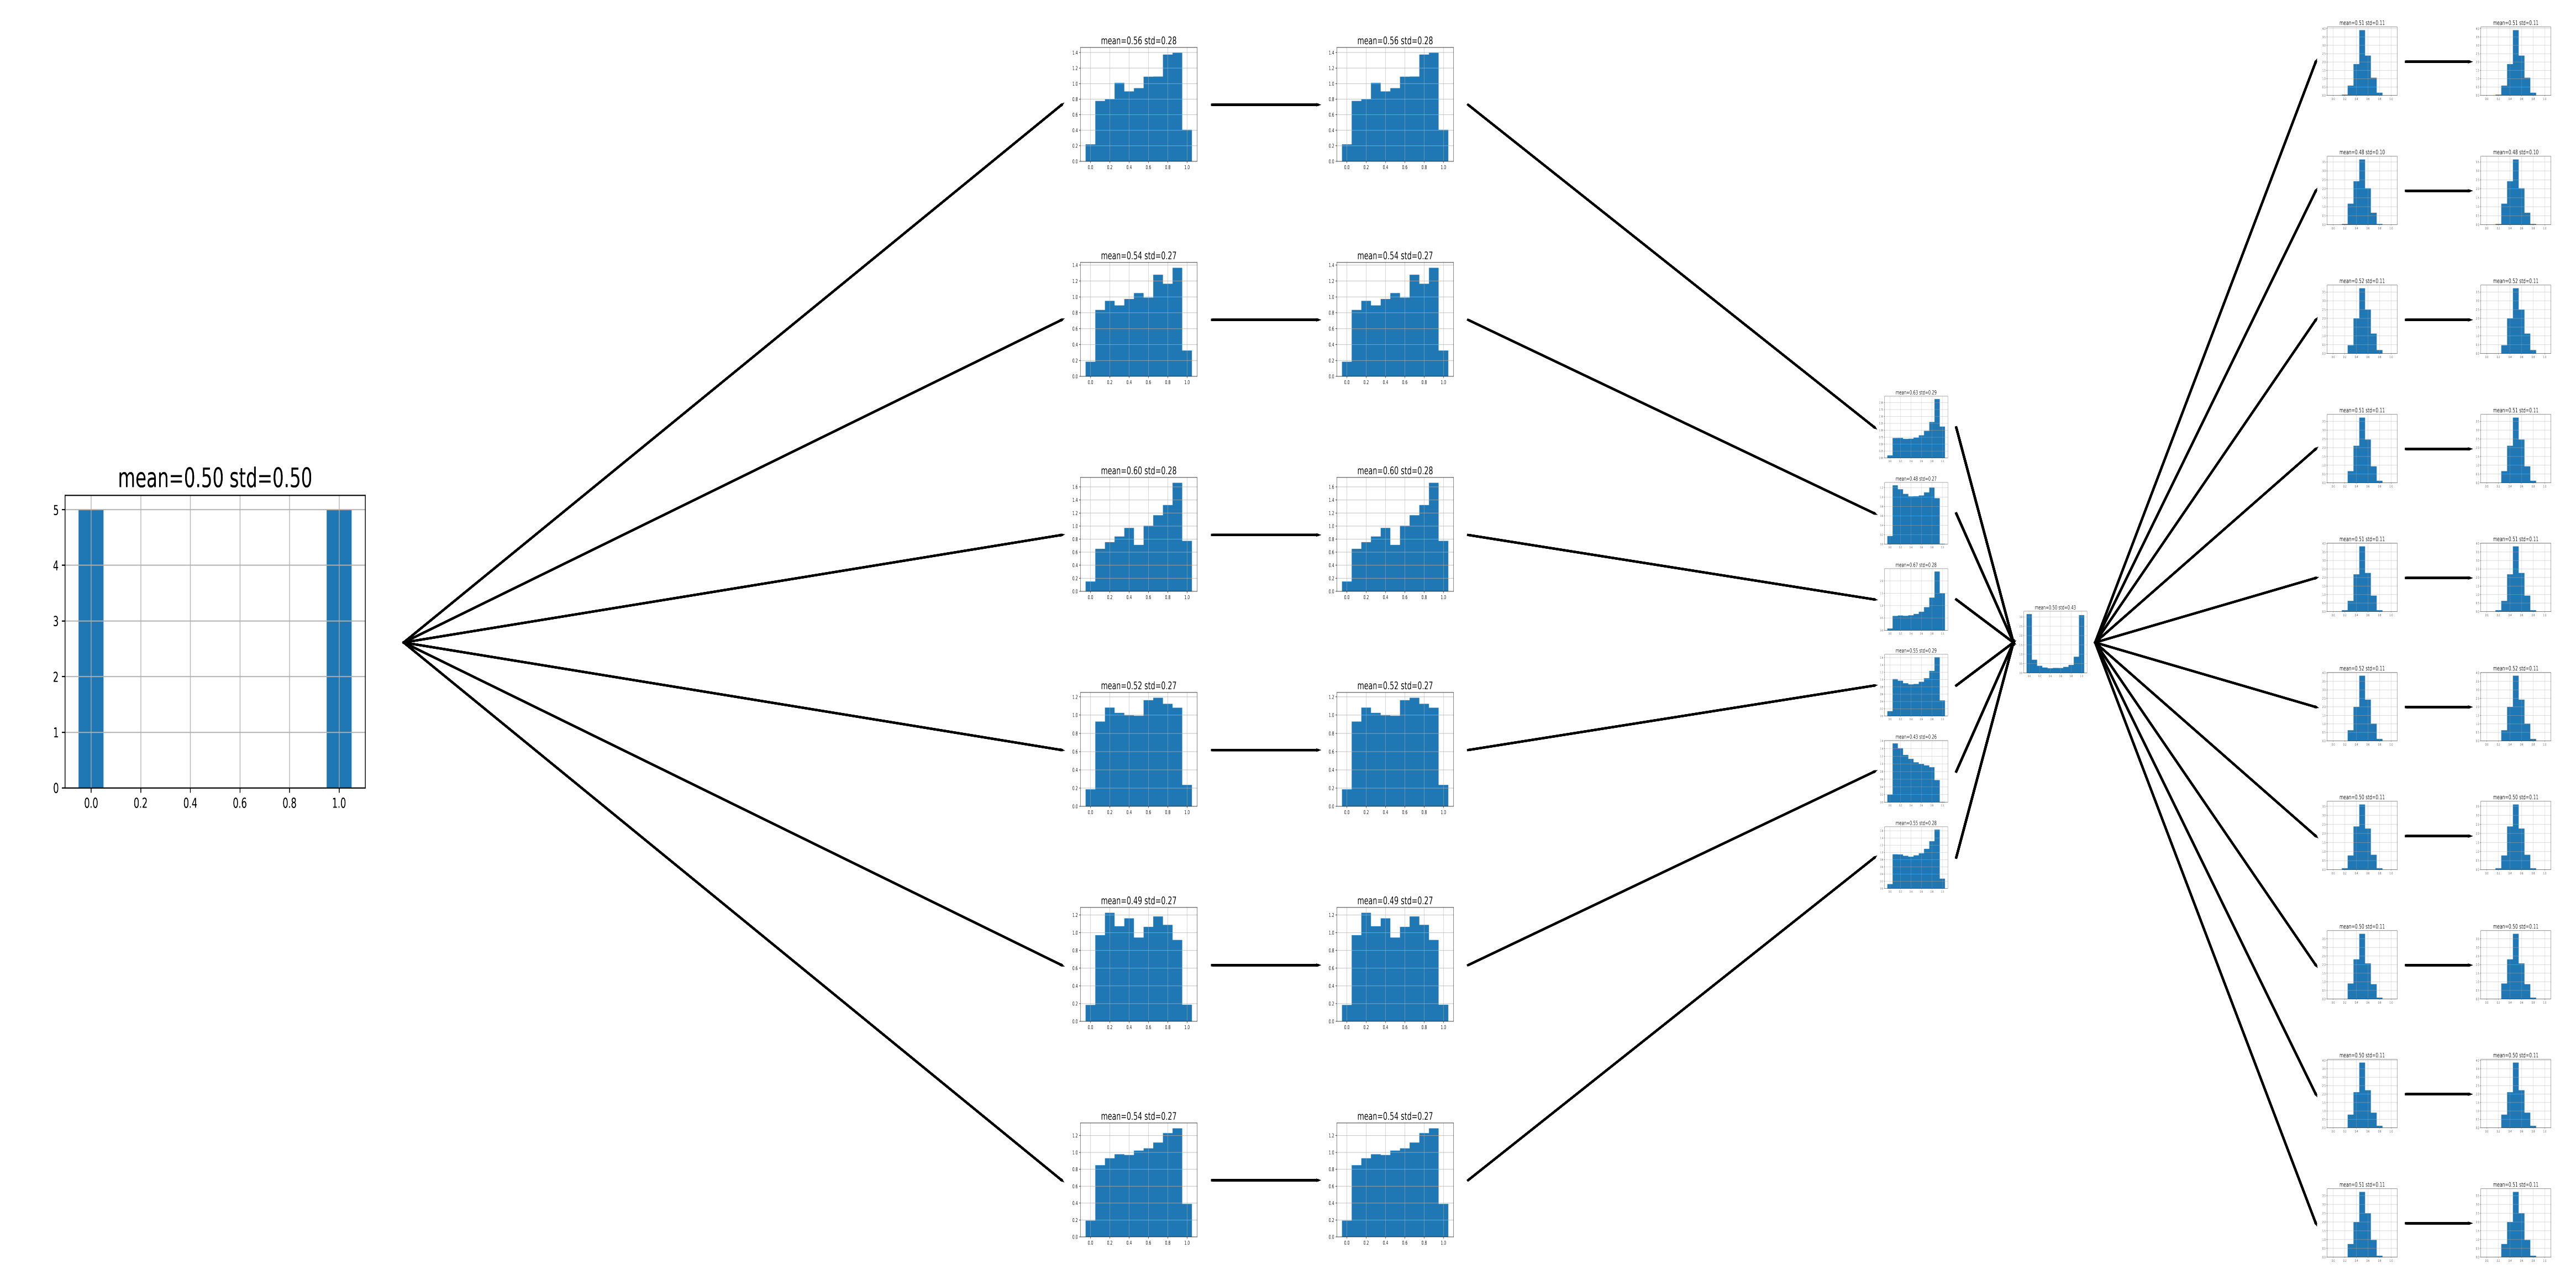

In [44]:
reload_modules()
viz_hist = bimonn_viz.BimonnHistogramVizualiser(model=model2, inpt=img.cuda(), dpi=300);
viz_hist.draw(figsize=(20, 10), dpi=300)


In [45]:
vizf = bimonn_viz.BimonnForwardVizualiser(model=model2, inpt=img.cuda())
vizf.draw(figsize=(20, 10))

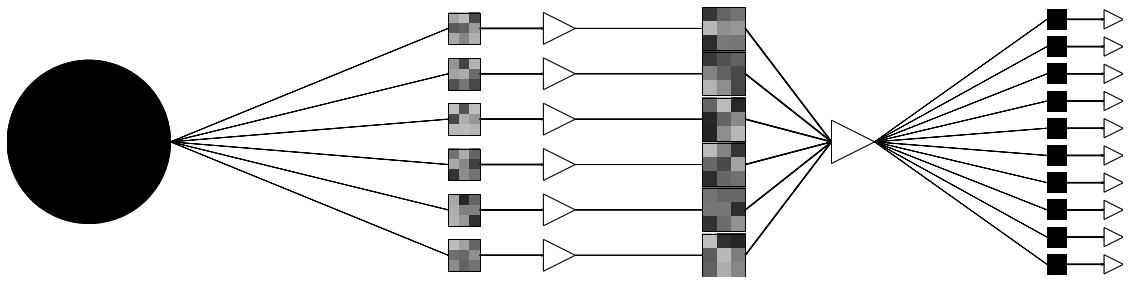

In [48]:
bimonn_viz.BimonnVizualiser(model2).draw(figsize=(20, 10))


# Results analysis

In [3]:
%matplotlib inline

In [3]:
reload_modules()
# tb_path = ("deep_morpho/results/DGMM_2022/sandbox/1/axspa_roi/version_7")
# tb_path = "/hdd/aouadt/these/projets/3d_segm/deep_morpho/results/results_tensorboards/Bimonn_exp_56/sandbox/2/softplus/diskorect/opening/disk/version_1"
tb_path = "deep_morpho/results/results_tensorboards/sandbox/sybisel/softplus/diskorect/dilation/disk/version_7"
# tb_path = "/hdd/aouadt/these/projets/3d_segm/deep_morpho/results/results_tensorboards/test_refactor_lui/bisel2/softplus/diskorect/dilation/disk/version_0"

tb_path = join(tb_path, 'checkpoints', os.listdir(join(tb_path, 'checkpoints'))[0])

model = models.LightningBiMoNN.load_from_checkpoint(tb_path)
model.to(device)

loss = nn.BCELoss()

[]

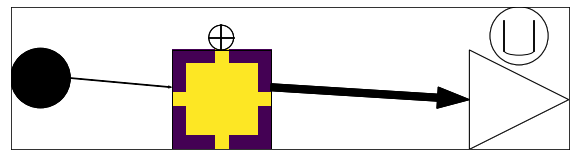

In [4]:
fig_weights = bimonn_viz.BimonnVizualiser(model.model, mode="closest").get_fig(figsize=(10, 10), axis='on')
fig_weights.axes[0].set_xticks([])
fig_weights.axes[0].set_yticks([])

In [19]:
layer = model.model.layers[0].bises[0]
selems, dists = layer.compute_selem_dist_for_operation_chan(
    weights=layer._normalized_weights, bias=layer.bias, chout=0, operation='dilation', closest_selem_distance_fn=layer.closest_selem_distance_fn)

In [16]:
layer.bias_bounds_dilation(normalized_weights=layer._normalized_weights[0, 0], S=morp.disk(3).astype(bool))

(-10.247111305594444, -9.817602396011353)

In [17]:
layer.bias

Parameter containing:
tensor([10.0949], device='cuda:0', requires_grad=True)

In [15]:
layer._normalized_weights.shape

torch.Size([1, 1, 7, 7])

In [6]:
dists

array([10.094945 , 10.096578 , 10.098693 , 10.10086  , 10.103041 ,
       10.105916 , 10.1097975, 10.114527 , 10.119529 , 10.125377 ,
       10.131406 , 10.137718 , 10.144101 , 10.15073  , 10.158813 ,
       10.166899 , 10.176176 , 10.187427 , 10.19892  , 10.210948 ,
       10.223225 , 10.566259 , 10.90991  , 11.254389 , 11.598917 ,
       11.943978 , 12.289112 , 12.6349   , 12.980974 , 13.32742  ,
       13.674029 , 14.020729 , 14.368019 , 14.716082 , 15.065973 ,
       15.415918 , 15.7662945, 16.11864  , 16.471004 , 16.823698 ,
       17.176966 , 17.530481 , 17.90513  , 18.280891 , 18.658264 ,
       19.035746 , 19.425068 , 19.816181 , 20.207355 ], dtype=float32)

#### Distance analysis, max distance

In [5]:
def distance_to_bounds(bound_fn, normalized_weights: torch.Tensor, bias: torch.Tensor, S: np.ndarray, v1: float = 0, v2: float = 1) -> float:
    assert np.isin(np.unique(S), [0, 1]).all(), "S must be binary matrix"
    lb, ub = bound_fn(normalized_weights=normalized_weights, S=S, v1=v1, v2=v2)
    dist_lb = lb + bias  # if dist_lb < 0 : lower bound respected
    dist_ub = -bias - ub  # if dist_ub < 0 : upper bound respected
    return dist_lb, dist_ub, lb, ub

def distance_to_dilation(normalized_weights: torch.Tensor, bias: torch.Tensor, S: np.ndarray, v1: float = 0, v2: float = 1) -> float:
    return distance_to_bounds(BiSE.bias_bounds_dilation, normalized_weights, bias, S, v1, v2)


def distance_to_erosion(normalized_weights: torch.Tensor, bias: torch.Tensor, S: np.ndarray, v1: float = 0, v2: float = 1) -> float:
    return distance_to_bounds(BiSE.bias_bounds_erosion, normalized_weights, bias, S, v1, v2)


def compute_selem_dist_for_operation_chan(_normalized_weight, bias, idx: int, operation: str, v1: float = 0, v2: float = 1):
    weights = _normalized_weight[idx, 0]
    weight_values = weights.unique().detach().cpu().numpy()
    bias = bias[idx]
    distance_fn = {'dilation': distance_to_dilation, 'erosion': distance_to_erosion}[operation]

    dists_lb = np.zeros_like(weight_values)
    dists_ub = np.zeros_like(weight_values)
    lb = np.zeros_like(weight_values)
    ub = np.zeros_like(weight_values)
    selems = []
    for value_idx, value in enumerate(weight_values):
        selem = (weights >= value).cpu().detach().numpy()
        dists_lb[value_idx], dists_ub[value_idx] , lb[value_idx], ub[value_idx] = distance_fn(weights, bias, selem, v1, v2)
        selems.append(selem)

    return selems, dists_lb, dists_ub, lb, ub

In [73]:
layer = model.model.layers[1].bise_0
selems, dists_lb, dists_ub, lb, ub = compute_selem_dist_for_operation_chan(layer._normalized_weight, layer.bias, 0, "dilation")

In [35]:
def plot_0_and_true(offset=None, true_idx=None, ax=None, label_hline='0', label_vline='true_closest', **kwargs):
    if ax is None:
        ax = plt.gca()
    if offset is not None:
        xmin, xmax = ax.get_xlim()
        plt.hlines(offset, xmin, xmax, colors='r', label=label_hline , **kwargs)
    if true_idx is not None:
        ymin, ymax = ax.get_ylim()
        plt.vlines(true_idx, ymin, ymax, colors='b', label=label_vline, **kwargs)


In [72]:
max_dist_interval

array([121.456825, 121.544754, 121.64051 , 121.74485 , 121.842766,
       121.95213 , 122.057884, 122.16737 , 122.27996 , 122.391785,
       122.50577 , 122.616425, 122.731445, 122.84823 , 122.96686 ,
       123.08565 , 123.20298 , 123.31858 , 123.430405, 123.55748 ,
       123.678406, 123.81208 , 123.93982 , 124.07225 , 124.174736,
       124.34528 , 124.499054, 124.676506, 124.849205, 125.01055 ,
       125.19075 , 125.38675 , 125.45886 , 125.723465, 125.98807 ,
       126.269806, 110.62233 , 118.80555 , 126.995026, 135.21216 ,
       143.68256 , 151.96188 , 160.58655 , 169.23476 , 177.6984  ,
       185.59547 , 195.03523 , 202.63504 , 210.55084 ], dtype=float32)

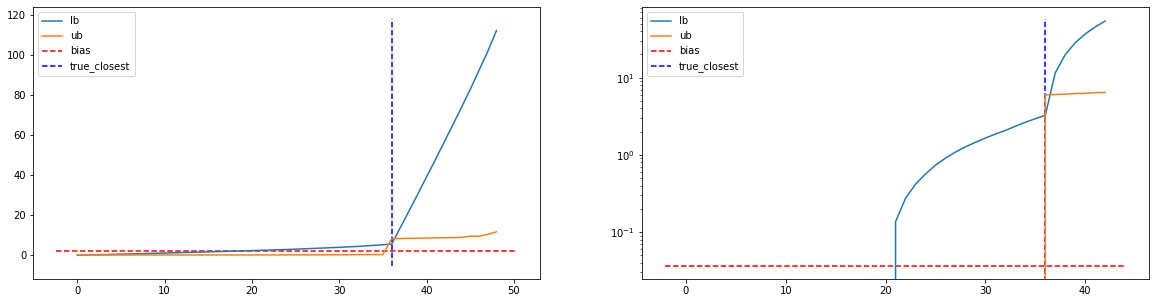

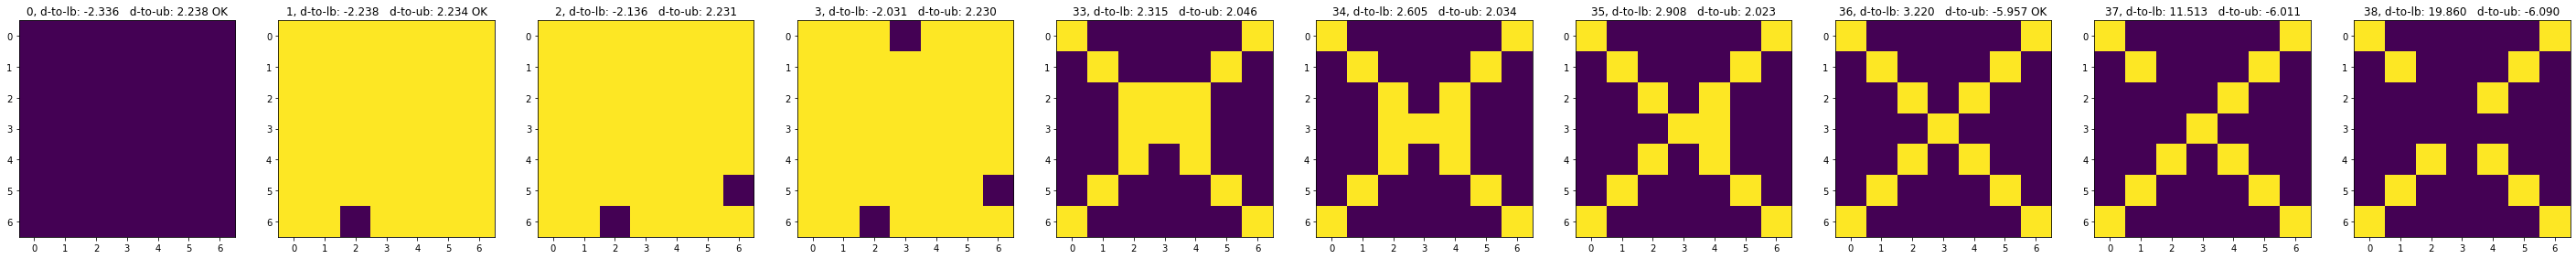

In [74]:
from deep_morpho.observables import PlotWeightsBiSE

PlotWeightsBiSE.get_figure_normalized_weights(layer._normalized_weight[0, 0], layer.bias, layer.activation_P)

true_idx = 36
b = -layer.bias.item()

plt.figure(figsize=(20, 5))

plt.subplot(121)
offset = 0.7
plt.plot(dists_lb + offset, label='dist_to_lb')
plt.plot(dists_ub + offset, label='dist_to_ub')
plot_0_and_true(offset, true_idx, linestyle='dashed')
plt.legend()
plt.yscale('log')

plt.subplot(122)
offset = 0.5
# plt.plot(np.maximum(dists_lb, dists_ub, np.zeros_like(dists_lb)) + offset, label='max_dist')
# plt.plot(np.maximum(dists_lb, 0) + np.maximum(0, dists_ub) + offset, label='sum_dist')

max_dist_interval = np.maximum(dists_lb, dists_ub, np.zeros_like(dists_lb)) + lb - ub
plt.plot(max_dist_interval + offset, label='max_dist_interval')
plt.title(f"max_dist_interval: {np.where(max_dist_interval == max_dist_interval[~np.isnan(max_dist_interval)].min())}")

# dist2 = (b >= lb) * np.maximum(dists_ub, 0) + (b <= ub) * np.maximum(dists_lb, 0)
# dist2[(ub < b) & (b < lb)] = np.nan
# dist2 = dist2 + np.max(dist2) * ((ub < b) & (b < lb))
# plt.title(f"dist2: {np.where(dist2 == dist2[~np.isnan(dist2)].min())}")
# plt.plot(dist2 + offset, label='dist2')

plot_0_and_true(offset, true_idx, linestyle='dashed')
plt.legend()
plt.yscale('log')


# plt.subplot(133)
# offset = 0
# plt.plot(np.maximum(dists_lb, 0) + np.maximum(0, dists_ub) + offset, label='sum_dist')
# plt.hlines(offset, 0, len(dists_lb) - 1, colors='r', label='0')
# plt.legend()
# plt.yscale('log')


plt.figure(figsize=(20, 5))
plt.subplot(121)
# offset = -2.3
offset = 0
# last_idx = 43
last_idx = len(lb)
plt.plot(lb[:last_idx] + offset, label='lb')
plt.plot(ub[:last_idx] + offset, label='ub')
plot_0_and_true(-layer.bias.item() + offset, true_idx, label_hline='bias', linestyle='dashed')

plt.legend()
# plt.yscale('log')

plt.subplot(122)
offset = -2.3
last_idx = 43
plt.plot(lb[:last_idx] + offset, label='lb')
plt.plot(ub[:last_idx] + offset, label='ub')
plot_0_and_true(-layer.bias.item() + offset, true_idx, label_hline='bias', linestyle='dashed')
plt.legend()
plt.yscale('log')


idx_operable = np.where(lb < ub)[0]
idx_to_show = []
for idx in idx_operable:
    for i in range(-3, 3):
        if 0 <= i + idx < len(lb):
            idx_to_show.append(idx + i)
idx_to_show = sorted(list(set(idx_to_show)))

ncols = len(idx_to_show)
fig, axs = plt.subplots(1, ncols, figsize=(ncols*5, 5))
for ax_idx, selem_idx in enumerate(idx_to_show):
# for ax_idx, selem_idx in enumerate(range(first_idx, last_idx)):
    axs[ax_idx].imshow(selems[selem_idx])
    title = f'{selem_idx}, d-to-lb: {dists_lb[selem_idx]:.3f}   d-to-ub: {dists_ub[selem_idx]:.3f}'
    if selem_idx in idx_operable:
        title += " OK"
    axs[ax_idx].set_title(title)


In [14]:
selems, dists = model.model.layers[0].bise_0.compute_selem_dist_for_operation_chan(0, "erosion")

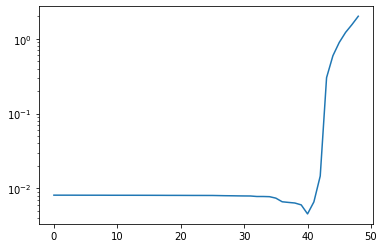

In [13]:
plt.plot(dists)
plt.yscale('log')

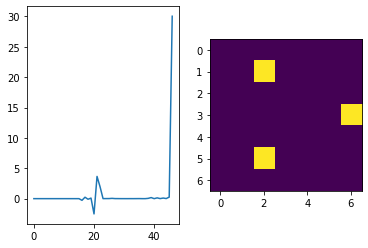

In [95]:
plt.subplot(121)
plt.plot(dists[2:] + dists[:-2] - 2 * dists[1:-1])

plt.subplot(122)
idx = np.abs(dists[2:] + dists[:-2] - 2 * dists[1:-1]).argmax()
plt.imshow(selems[idx])

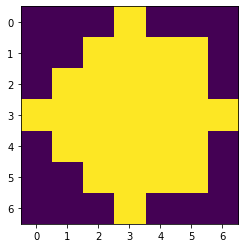

In [98]:
plt.imshow(selems[dists.argmin()])

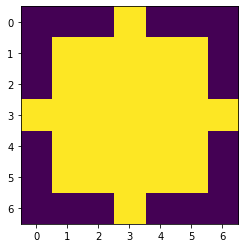

In [25]:
plt.imshow(selems[20])

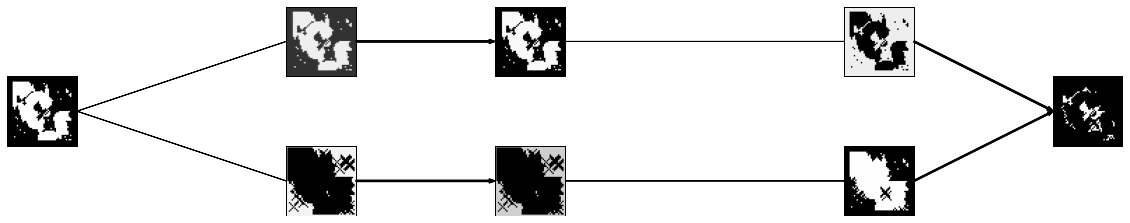

In [72]:
reload_modules()

morp_operation = morpop.ParallelMorpOperations.black_tophat(('dcross', 7))

# plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = mrda.InputOutputGeneratorDataset.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={'size': (50, 50), 'n_shapes': 20, 'max_shape': (20, 20), 
                     'p_invert': 0.5, 'n_holes': 10, 'max_shape_holes': (10, 10), 
                     'noise_proba': 0.02},
    device=device,
    morp_operation=morp_operation,
)

img, target = next(iter(dataloader))

vizf = bimonn_viz.BimonnForwardVizualiser(model=model.model, inpt=img.cuda())
vizf.draw(figsize=(20, 10))


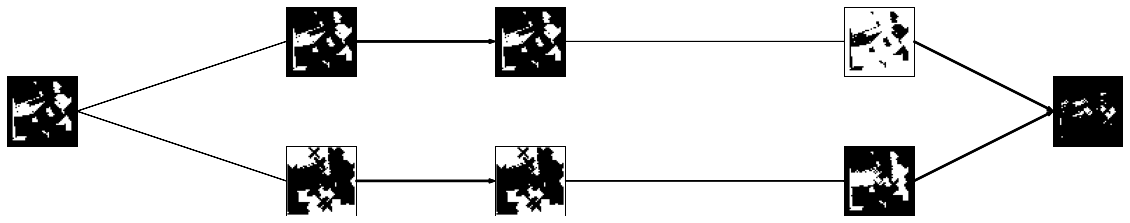

In [13]:
vizf = bimonn_viz.BimonnForwardVizualiser(model=model.model, inpt=img.cuda(), mode="binary")
vizf.draw(figsize=(20, 10))


In [25]:
all_outputs = model.model.forward_save(img.cuda())

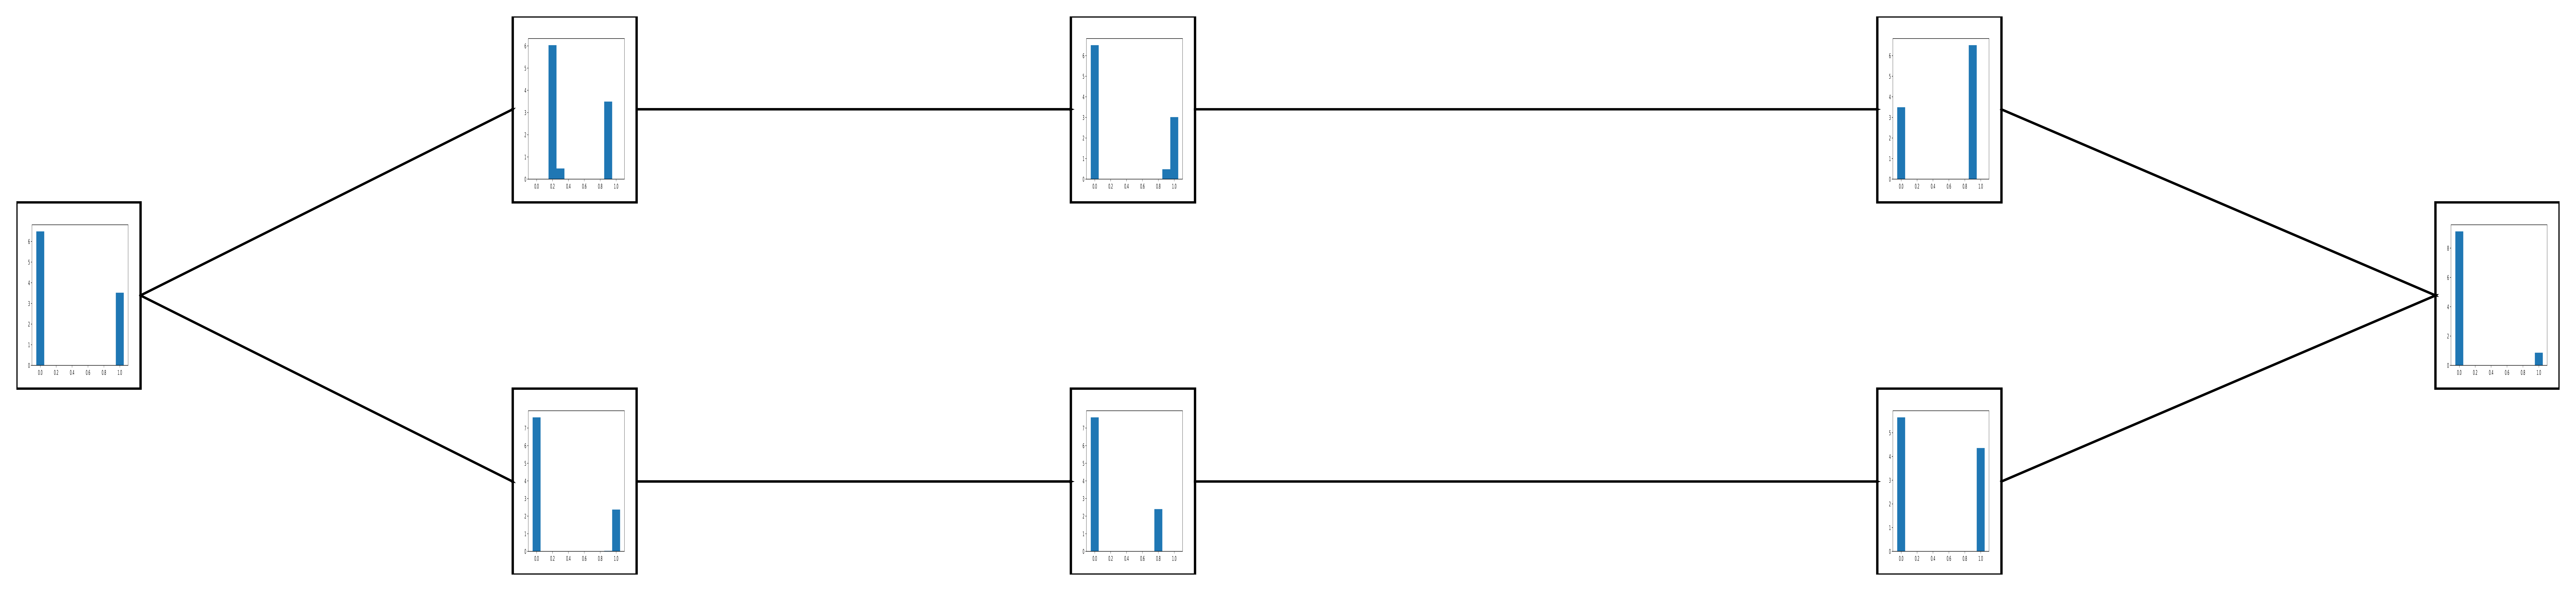

In [64]:
viz_hist = bimonn_viz.BimonnHistogramVizualiser(model=model.model, inpt=img.cuda(), dpi=600);
viz_hist.draw(figsize=(20, 10), dpi=600)



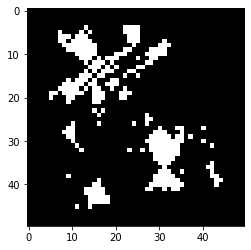

In [88]:
plt.imshow(target[0, 0].cpu().detach().numpy(), cmap='gray')

[]

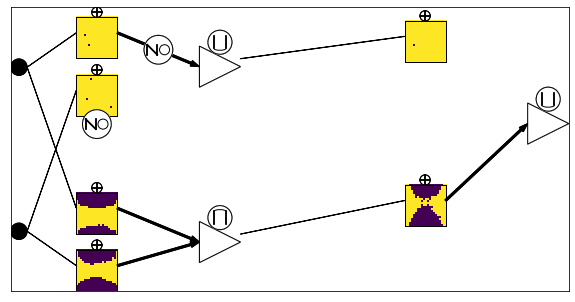

In [5]:
fig_binary = bimonn_viz.BimonnVizualiser(model.model, mode="closest").get_fig(figsize=(10, 10), axis='on')
fig_binary.axes[0].set_xticks([])
fig_binary.axes[0].set_yticks([])

In [26]:
fig_weights.savefig("axspa_weights_2.svg")

In [27]:
fig_binary.savefig("axspa_binary_2.svg")


In [9]:
fig_weights.axis('on')

AttributeError: 'Figure' object has no attribute 'axis'

In [2]:
fig_weights.savefig("black_tophat_weights_diskorect_dcross.png")


NameError: name 'fig_weights' is not defined

In [12]:
res = -0.16-0.22-0.13-.1-.17-.14-.17-.2-.38-.21-.22-.1-.22-.41-.39-.4-.19-.12-.37-.39-.27-.37-.38-.11-.2-.39-.38-.39-.24-.09-.23-.2-.37-.21-.19-.15-.17-.1-.13-.22-.16+.54+.35+.55+.37+.54+.36+.55+.36
def tanh_threshold(x):
    return 1/2 * torch.tanh(x) + 1/2
tanh_threshold(torch.tensor(res - 6.09))

tensor(0.)

In [ ]:
model.model

BiMoNN(
  (layer1): BiSEL(
    (bise_0): BiSE(
      (conv): Conv2d(1, 2, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=replicate)
      (softplus_layer): Softplus(beta=1, threshold=20)
      (weight_threshold_layer): IdentityLayer()
      (activation_threshold_layer): TanhLayer()
    )
    (lui_0): LUI(
      (threshold_layer): TanhLayer()
      (linear): Linear(in_features=1, out_features=1, bias=True)
      (softplus_layer): Softplus(beta=1, threshold=20)
    )
    (lui_1): LUI(
      (threshold_layer): TanhLayer()
      (linear): Linear(in_features=1, out_features=1, bias=True)
      (softplus_layer): Softplus(beta=1, threshold=20)
    )
  )
  (layer2): BiSEL(
    (bise_0): BiSE(
      (conv): Conv2d(1, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=replicate)
      (softplus_layer): Softplus(beta=1, threshold=20)
      (weight_threshold_layer): IdentityLayer()
      (activation_threshold_layer): TanhLayer()
    )
    (bise_1): BiSE(
      (con

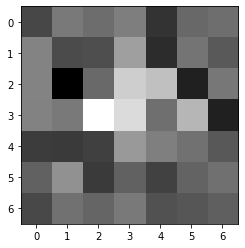

In [29]:
node10 = model.model.layers[1].bises[0]
weight = node10._normalized_weight[0].detach().cpu().squeeze()
plt.imshow(weight, cmap='gray')

In [65]:
lui11 = model.model.layers[1].luis[0]
print(lui11.coefs)
print(lui11.bias)

tensor([[1.3375, 1.8092]], device='cuda:0', grad_fn=<SoftplusBackward>)
tensor([-1.7956], device='cuda:0', grad_fn=<SubBackward0>)


In [16]:

morp_operation = morpop.ParallelMorpOperations.black_tophat(('disk', 3))


dataloader = mrda.InputOutputGeneratorDataset.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={'size': (50, 50), 'n_shapes': 20, 'max_shape': (20, 20), 
                     'p_invert': 0.5, 'n_holes': 10, 'max_shape_holes': (10, 10), 
                     'noise_proba': 0.02},
    device=device,
    morp_operation=morp_operation,
)

img, target = next(iter(dataloader))
img = img.cuda()

In [31]:
lui00

LUI(
  (threshold_layer): TanhLayer()
  (linear): Linear(in_features=1, out_features=1, bias=True)
  (softplus_layer): Softplus(beta=1, threshold=20)
)

In [55]:
pred_id = node10(lui00(node00(img)[:, 0:1, ...]))
pred_op = node11(lui01(node00(img)[:, 1:2, ...]))
pred_model = model.model(img)
pred_lui = lui11(torch.cat([pred_id, pred_op], dim=1))


In [56]:
def plot_tensor(img):
    plt.imshow(img.detach().cpu().numpy(), cmap='gray')

Text(0.5, 1.0, 'Opening Output')

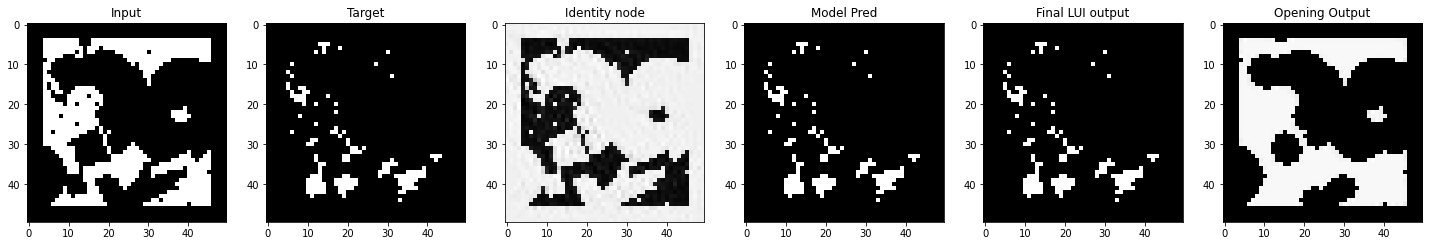

In [58]:
plt.figure(figsize=(25, 5))
plt.subplot(161)
plot_tensor(img[0, 0])
plt.title('Input')

plt.subplot(162)
plot_tensor(target[0, 0])
plt.title('Target')

plt.subplot(163)
plot_tensor(pred_id[0, 0])
plt.title('Identity node')

plt.subplot(164)
plot_tensor(pred_model[0, 0])
plt.title('Model Pred')

plt.subplot(165)
plot_tensor(pred_lui[0, 0])
plt.title('Final LUI output')


plt.subplot(166)
plot_tensor(pred_op[0, 0])
plt.title('Opening Output')

In [64]:
pred_id[0, 0].max()

tensor(0.9800, device='cuda:0', grad_fn=<MaxBackward1>)

In [6]:
node.closest_selem.shape

(7, 7, 1)

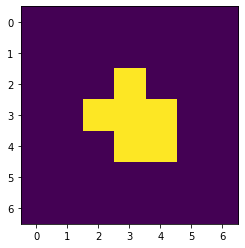

In [7]:
plt.imshow(node.closest_selem[..., 0])

In [6]:
dists = {"dilation": {"lb": [], "ub": []}, "erosion": {"lb": [], "ub": []}}
dist_fn = {"dilation": node.bias_bounds_dilation, "erosion": node.bias_bounds_erosion}

weight_values = np.unique(weight)

for op in dists.keys():
    for thresh in weight_values:
        selem = (weight >= thresh).numpy()
        lb, ub = dist_fn[op](normalized_weights=weight, S=selem, v1=0, v2=1)
        dists[op]["lb"].append((lb + bias).item())
        dists[op]["ub"].append((-bias - ub).item())
    



-4.24459171295166


Text(0.5, 1.0, 'erosion, ub')

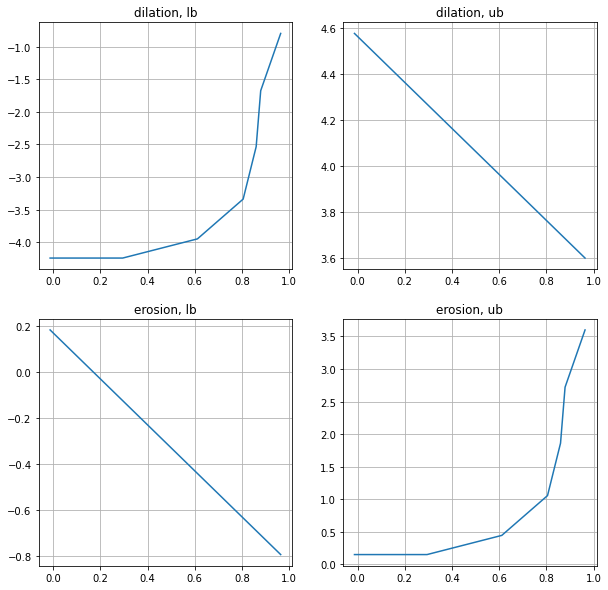

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

print(bias.item())

axs[0, 0].plot(weight_values, dists['dilation']['lb'])
axs[0, 0].grid('on')
axs[0, 0].set_title('dilation, lb')

axs[0, 1].plot(weight_values, dists['dilation']['ub'])
axs[0, 1].grid('on')
axs[0, 1].set_title('dilation, ub')

# axs[0, 2].plot(weight_values, np.maximum(dists['dilation']['ub'], dists['dilation']['lb']))
# axs[0, 2].grid('on')
# axs[0, 2].set_title('dilation, max')

axs[1, 0].plot(weight_values, dists['erosion']['lb'])
axs[1, 0].grid('on')
axs[1, 0].set_title('erosion, lb')

axs[1, 1].plot(weight_values, dists['erosion']['ub'])
axs[1, 1].grid('on')
axs[1, 1].set_title('erosion, ub')

# axs[1, 2].plot(weight_values, np.maximum(dists['erosion']['ub'], dists['erosion']['lb']))
# axs[1, 2].grid('on')
# axs[1, 2].set_title('erosion, max')


In [6]:
reload_modules()

morp_operation = arm.SequentialMorpOperations(
    name="opening", 
    selems=[morp.disk(3), morp.disk(3)],
    operations=['erosion', 'dilation'],
    device='cpu'
)

fig = plt.figure()
for selem_idx, selem in enumerate(morp_operation.selems):
    ax = fig.add_subplot(1, len(morp_operation), selem_idx + 1)
    ax.imshow(selem)
    ax.set_title(morp_operation.operations[selem_idx])

dataloader = mrda.MultiRectDatasetGenerator.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_rotated_diskorect,
    random_gen_args={'size': (50, 50), 'n_shapes': 15, 'max_shape': (15, 15), 'p_invert': .5,
                    'border': (4, 4)},
    device=device,
    morp_operation=morp_operation,
)



AttributeError: module 'general.array_morphology' has no attribute 'SequentialMorpOperations'

/hdd/aouadt/these/projets/3d_segm/general/array_morphology.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(ar).unsqueeze(0).unsqueeze(0).float().to(device)


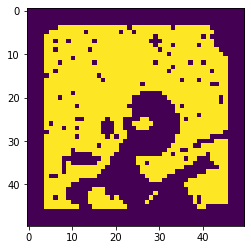

In [31]:
img, target = next(iter(dataloader))
img = img.to('cpu')
plt.imshow(img[0, 0].cpu().detach())

In [37]:
model.to(device)
img = img.to(device)
model(img).unique()

tensor([0.0053, 0.0139, 0.0142, 0.0156, 0.0166, 0.0167, 0.0169, 0.0185, 0.0197,
        0.0198, 0.0221, 0.0244, 0.0267, 0.0267, 0.0368, 0.0439, 0.0470, 0.0978,
        0.7166, 1.0000, 1.0053], device='cuda:0', grad_fn=<Unique2Backward>)

In [32]:
otp1 = model.model.bises[1](img)

loss(model(img).squeeze(), target).backward()

IndexError: list index out of range

In [35]:
print(model.model.bises[1].weight.grad)

tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:0')


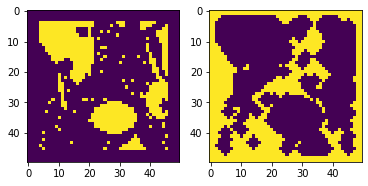

In [14]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(img[0, 0].cpu().detach())

ax = fig.add_subplot(122)
ax.imshow(otp1[0, 0].cpu().detach())


Parameter containing:
tensor([-3.0075], device='cuda:0', requires_grad=True)


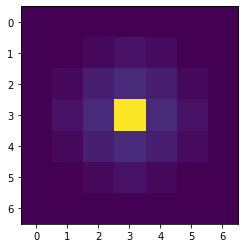

In [51]:
plt.imshow(model.model.bises[0]._normalized_weight[0, 0].detach().cpu())
print(model.model.bises[0].bias)

In [44]:
loss(model.model.bises[0](img).squeeze(), target).backward()

In [49]:
model.model.bises[0].weight_P.grad

tensor([0.], device='cuda:0')

In [19]:
ero_layer = model.model.bises[0]
otp1 = ero_layer.conv._conv_forward(img, ero_layer._normalized_weight, ero_layer.bias)
otp2 = ero_layer.activation_threshold_layer(otp1)

NameError: name 'img' is not defined

In [67]:
img.max()

tensor(1., device='cuda:0')

In [55]:
print(otp1[0, 0].min())
print(otp1[0, 0].max())


tensor(-3.0075, device='cuda:0', grad_fn=<MinBackward1>)
tensor(-1.0926, device='cuda:0', grad_fn=<MaxBackward1>)


In [64]:
ero_layer.activation_threshold_layer.threshold_fn(-3.0075 )

<function deep_morpho.threshold_fn.tanh_threshold(x)>

In [59]:
ero_layer.bias

Parameter containing:
tensor([-3.0075], device='cuda:0', requires_grad=True)

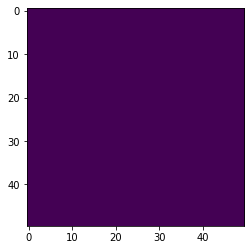

In [61]:
plt.imshow(otp2[0, 0].cpu().detach())

In [8]:
reload_modules()
tb_path = ("/hdd/aouadt/these/projets/3d_segm"
          "/deep_morpho/results/Bimonn_exp_19/dilation_size_7x7/version_0/checkpoints/epoch=0-step=31249.ckpt")

model = models.LightningBiMoNN.load_from_checkpoint(tb_path)
model.to(device)

ero_layer = model.model.bises[0]

ero_layer.find_all_selem_dilation()

[]

In [9]:
%%timeit
ero_layer.find_all_selem_dilation()

15.9 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
ero_layer._normalized_weight.unique().shape

torch.Size([49])

# Landscape analysis

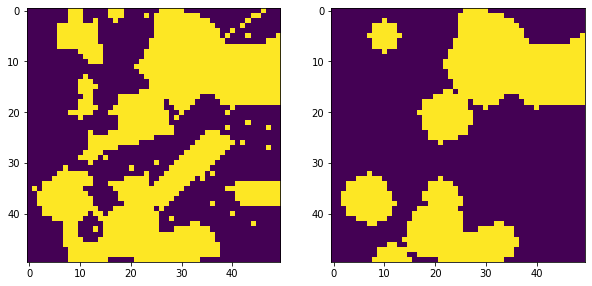

In [4]:
reload_modules()
selem = morp.disk(3)


morp_operation = morpop.ParallelMorpOperations.opening(('disk', 3))

# plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = mrda.InputOutputGeneratorDataset.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={'size': (50, 50), 'n_shapes': 20, 'max_shape': (20, 20), 
                     'p_invert': 0.5, 'n_holes': 10, 'max_shape_holes': (10, 10), 
                     'noise_proba': 0.02, "border": (0, 0)},
    device="cpu",
    morp_operation=morp_operation,
    do_symetric_output=True,
)

img, target = next(iter(dataloader))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(img[0, 0].cpu().detach())

plt.subplot(122)
plt.imshow(target[0, 0].cpu().detach())


In [62]:
reload_modules()

def get_net(init_bias_value=0, activation_P=0, threshold_mode="tanh_symetric"):
    return bimonn.BiMoNN(
        kernel_size=[7, 7],
        channels=[1,1, 1],
        atomic_element="sybisel",
        threshold_mode={"weight": "softplus", "activation": threshold_mode},
        activation_P=activation_P,
        constant_activation_P=False,
        init_weight_mode=bise_base.InitBiseEnum.CUSTOM_HEURISTIC,
        bias_optim_mode=bise_base.BiseBiasOptimEnum.RAW,
        init_bias_value_bise=init_bias_value,
        weights_opim_mode=bise_base.BiseWeightsOptimEnum.NORMALIZED,
        input_mean=0,
    )


In [61]:
net.layers[0].bises[0].set_bias(torch.tensor([-3]))
net.layers[0].bises[0].bias

Parameter containing:
tensor([-3], requires_grad=True)

In [104]:
net = get_net(activation_P=0, init_bias_value=.1)

for param in net.parameters():
    net.zero_grad()

net.cuda()
loss = dmloss.MaskedMSELoss(border=(4, 4))
loss_value = loss(net(img.cuda()), target.cuda())
loss_value.backward()

for name, param in net.named_parameters():
    if param is not None:
        if "weight" in name:
            continue
        print("==")
        print(name, param.grad)

==
layer1.bise_0.activation_threshold_layer.P_ tensor([0.], device='cuda:0')
==
layer1.bise_0.bias_handler.param tensor([0.], device='cuda:0')
==
layer1.lui_0.activation_threshold_layer.P_ None
==
layer1.lui_0.bias_handler.param None
==
layer2.bise_0.activation_threshold_layer.P_ tensor([-0.0537], device='cuda:0')
==
layer2.bise_0.bias_handler.param tensor([0.], device='cuda:0')
==
layer2.lui_0.activation_threshold_layer.P_ None
==
layer2.lui_0.bias_handler.param None


In [107]:
print(net.layers[1].bises[0].activation_P.grad)
print(net.layers[1].bises[0].bias.grad)
print("loss:", loss_value)

tensor([-0.0537], device='cuda:0')
tensor([0.], device='cuda:0')
loss: tensor(1., device='cuda:0', grad_fn=<MseLossBackward0>)


In [6]:
losses = {
    # "dice": DiceLoss(),
    # "bce": nn.BCELoss(),
    # "mse": nn.MSELoss(),
    # 'bcelogits': nn.BCEWithLogitsLoss(),
    "MaskedBCENormalizedLoss": partial(dmloss.MaskedBCENormalizedLoss, vmin=-1, vmax=1),
    "MaskedNormalizedDiceLoss": partial(dmloss.MaskedNormalizedDiceLoss, vmin=-1, vmax=1),
    # "MaskedBCELoss": dmloss.MaskedBCELoss,
    "MaskedMSELoss": dmloss.MaskedMSELoss,
}


In [20]:
def fc(a=2, b=4):
    return a, b

fc1 = partial(fc, 3)
print(fc1(5))

(3, 5)


In [158]:
# all_P_bise = [0]
all_P_bise = np.linspace(-.1, .1, 51)
all_bias_bise = np.linspace(-.5, .5, 51)
# all_bias_bise = np.linspace(0.4, 0.6, 50)

values = {}
grad_P_dict = {}
grad_bias_dict = {}

threshold_mode = 'tanh_symetric'
net = get_net()
net.to(device)

img = torch.zeros_like(target) + 0.5

for loss_name, loss in losses.items():
    loss_values = np.zeros((len(all_P_bise), len(all_bias_bise)))
    grad_bias_values = [np.zeros((len(all_P_bise), len(all_bias_bise))) for _ in range(len(net))]
    grad_P_values = [np.zeros((len(all_P_bise), len(all_bias_bise))) for _ in range(len(net))]

    for idx1, P_bise in tqdm(enumerate(all_P_bise)):
        for idx2, bias_bise in enumerate(all_bias_bise):
            for param in net.parameters():
                if param.grad is not None:
                    param.grad.zero_()
                
            for layer in net.layers:
                layer.bises[0].set_bias(torch.zeros_like(layer.bises[0].bias) + bias_bise)
                layer.bises[0].set_activation_P(torch.zeros_like(layer.bises[0].activation_P) + P_bise)
#             net.layer1.bises[0].set_bias(torch.zeros_like(net.layer1.bises[0].bias) + bias_bise)
#             net.layer2.bises[0].set_bias(torch.zeros_like(net.layer1.bises[0].bias) + bias_bise)

#             net.layer1.bises[0].set_activation_P(torch.zeros_like(net.layer1.bises[0].activation_P) + P_bise)
#             net.layer2.bises[0].set_activation_P(torch.zeros_like(net.layer1.bises[0].activation_P) + P_bise)

            loss_value = loss(border=(4, 4))(net(img.cuda()), target.cuda())
            loss_value.backward()
            loss_values[idx1, idx2] = loss_value.cpu().detach().item()
            
            for idx in range(len(net)):
                grad_bias_values[idx][idx1, idx2] = net.layers[idx].bises[0].bias.grad
                grad_P_values[idx][idx1, idx2] = net.layers[idx].bises[0].activation_P.grad
            
    values[threshold_mode, loss_name] = loss_values
    grad_P_dict[threshold_mode, loss_name] = grad_P_values

    grad_bias_dict[threshold_mode, loss_name] = grad_bias_values

51it [00:16,  3.12it/s]
51it [00:19,  2.63it/s]
51it [00:17,  3.00it/s]


Text(0.5, 1.0, 'Grad P')

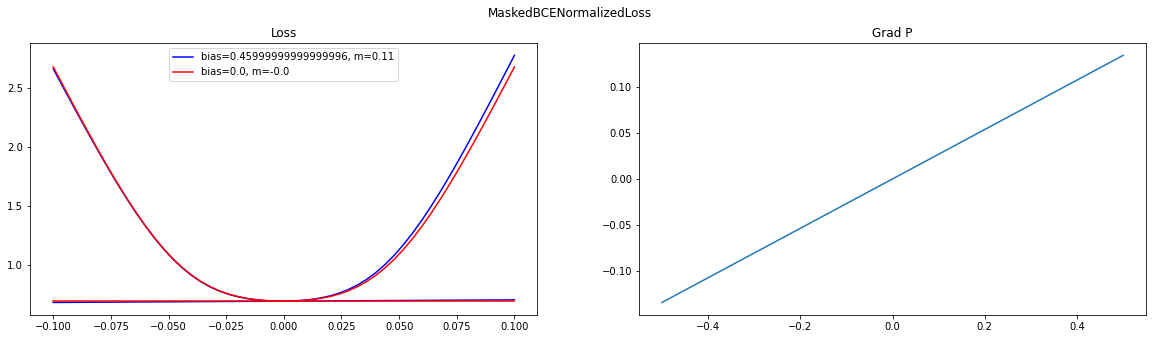

In [179]:
plt.figure(figsize=(20, 5))

loss_type = "MaskedBCENormalizedLoss"
# loss_type = "MaskedMSELoss"
mid = len(all_bias_bise) // 2
lossv = values['tanh_symetric',loss_type]
m_not_zero = (lossv[mid-1, mid + offset] - lossv[mid+1, mid + offset]) / (all_P_bise[mid - 1] - all_P_bise[mid + 1])
m_zero = (lossv[mid-1, mid] - lossv[mid+1, mid]) / (all_P_bise[mid - 1] - all_P_bise[mid + 1])

plt.suptitle(loss_type)

plt.subplot(121)
offset = 23
plt.plot(all_P_bise, lossv[:,mid + offset], label=f'bias={all_bias_bise[mid + offset]}, m={m_not_zero:.2f}', c='b')
plt.plot(
    [all_P_bise[0], all_P_bise[-1]], 
    [lossv[mid, mid + offset] - m_not_zero * (all_P_bise[mid] - all_P_bise[0]), lossv[mid, mid + offset] + m_not_zero * (all_P_bise[-1] - all_P_bise[mid])],
    c='b'
)
plt.plot(all_P_bise, lossv[:,mid], label=f'bias={all_bias_bise[mid]}, m={m_zero}', c='r')
plt.plot(
    [all_P_bise[0], all_P_bise[-1]], 
    [lossv[mid, mid] - m_zero * (all_P_bise[mid] - all_P_bise[0]), lossv[mid, mid] + m_zero * (all_P_bise[-1] - all_P_bise[mid])],
    c='r'
)
plt.legend()
plt.title('Loss')

plt.subplot(122)
plt.plot(all_bias_bise, grad_P_dict['tanh_symetric',loss_type][1][len(all_P_bise)//2])
plt.title('Grad P')

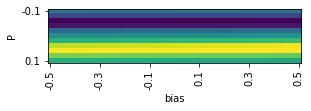

In [135]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(grad_P_dict['tanh_symetric', 'MaskedMSELoss'][1])
# plt.imshow(values['tanh_symetric', 'MaskedMSELoss'])
plt.ylabel('P')
plt.xlabel('bias')
plt.xticks(range(0, len(all_bias_bise), 10), [f"{k:.2}" for k in all_bias_bise][::10], rotation=90);
plt.yticks(range(0, len(all_P_bise), 10), [f"{k:.2}" for k in all_P_bise][::10]);

# plt.subplot(122)
# plt.imshow(np.log(loss_values))
# plt.ylabel('P bise')
# plt.xlabel('P lui')
# plt.xticks(range(len(all_P_lui)), [f"{k:.2}" for k in all_P_lui], rotation=90);
# plt.yticks(range(len(all_P_bise)), [f"{k:.2}" for k in all_P_bise]);

In [136]:
def plot_landscape(threshold_mode, losses=losses, grad_P_dict=grad_P_dict, grad_bias_dict=grad_bias_dict):
    XX, YY = np.meshgrid(all_bias_bise, all_P_bise)


    fig, axs = plt.subplots(3, 3, subplot_kw={"projection": "3d"}, figsize=(12, 12))
    fig.suptitle(f'threshold: {threshold_mode}')

#     idxs = [(0, 0), (0, 1), (1, 0), (1, 1)]
    keys = list(losses.keys())

    for idx in range(len(keys)):
#         ax_idx = idxs[idx]
        surf = axs[0, idx].plot_surface(XX, YY, values[threshold_mode, keys[idx]], label=keys[idx])
        axs[0, idx].set_ylabel('P')
        axs[0, idx].set_xlabel('bias')
        axs[0, idx].set_title(f'loss {keys[idx]}')
    
    for idx in range(len(keys)):
#         ax_idx = idxs[idx]
        surf = axs[1, idx].plot_surface(XX, YY, grad_P_dict[threshold_mode, keys[idx]], label=keys[idx])
        # surf = axs[1, idx].plot_surface(XX, YY, np.zeros_like(XX), label="zero", color="red")
        axs[1, idx].set_ylabel('P')
        axs[1, idx].set_xlabel('bias')
        axs[1, idx].set_title(f'grad P {keys[idx]}')

    for idx in range(len(keys)):
#         ax_idx = idxs[idx]
        surf = axs[2, idx].plot_surface(XX, YY, grad_bias_dict[threshold_mode, keys[idx]], label=keys[idx])
        surf = axs[2, idx].plot_surface(XX, YY, np.zeros_like(XX), label="zero", color="red")
        axs[2, idx].set_ylabel('P')
        axs[2, idx].set_xlabel('bias')
        axs[2, idx].set_title(f'grad bias {keys[idx]}')
        
    plt.show()

In [139]:
grad_P_dict['tanh_symetric', 'MaskedBCENormalizedLoss'][1][5, -1]

0.13414114713668823

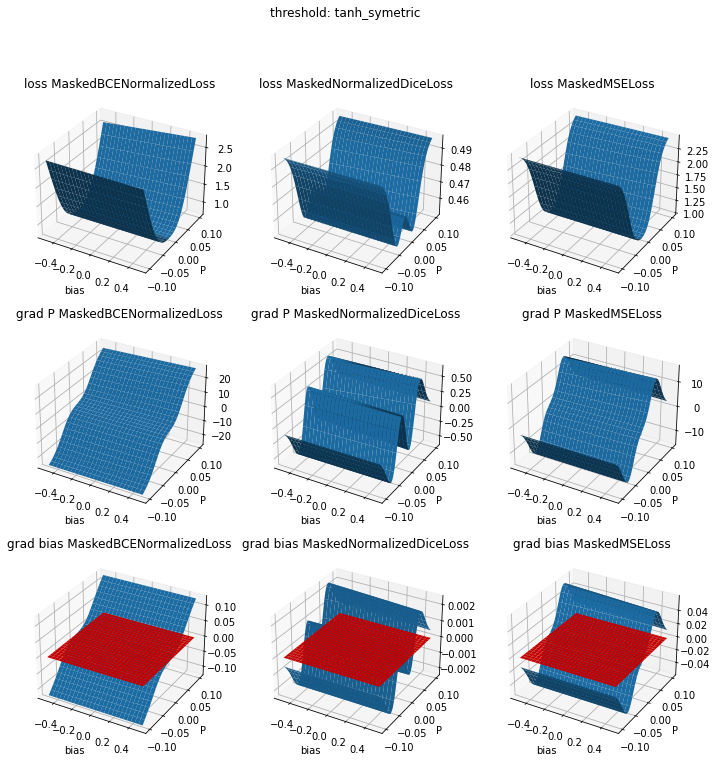

In [180]:
layer_idx = 1
plot_landscape(
    'tanh_symetric', 
    grad_P_dict={k: v[layer_idx] for k, v in grad_P_dict.items()}, 
    grad_bias_dict={k: v[layer_idx] for k, v in grad_bias_dict.items()}, 
)

<IPython.core.display.Javascript object>


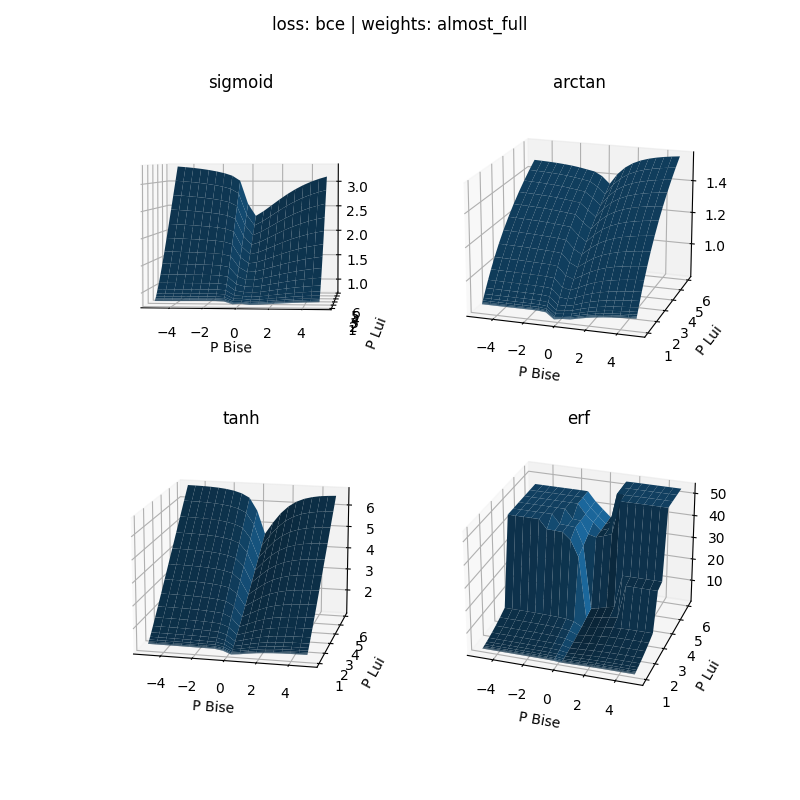

In [118]:
loss_name = "bce"
weight_name = "almost_full"  #almost_full
threshold_modes = ['sigmoid', 'arctan', 'tanh', 'erf',]

plot_landscape(threshold_modes, weight_name, loss_name,)

<IPython.core.display.Javascript object>


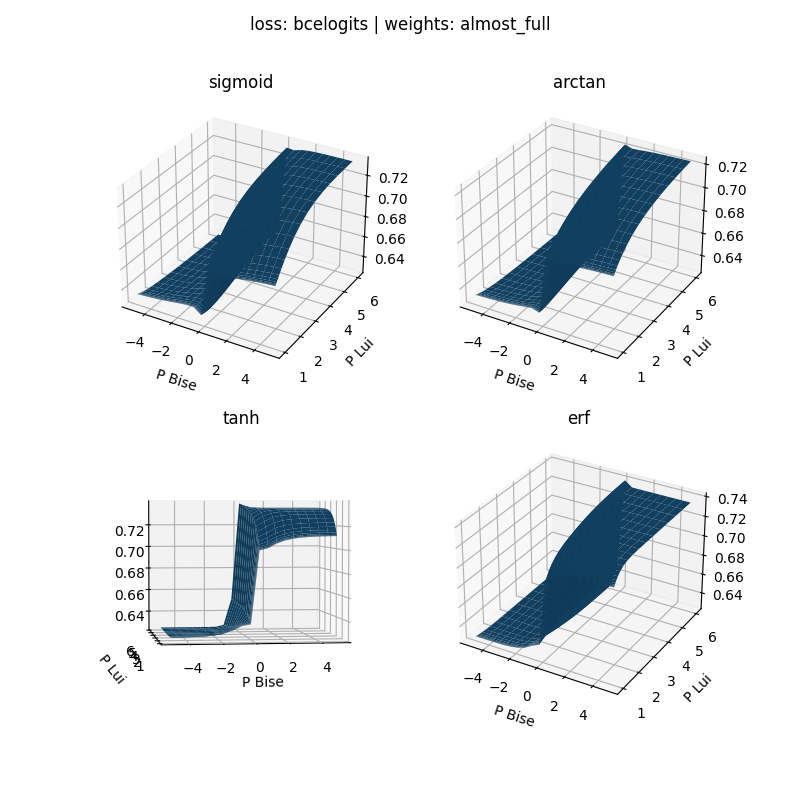

In [122]:
loss_name = "bcelogits"
weight_name = "almost_full"  #almost_full
threshold_modes = ['sigmoid', 'arctan', 'tanh', 'erf',]

plot_landscape(threshold_modes, weight_name, loss_name,)

<IPython.core.display.Javascript object>


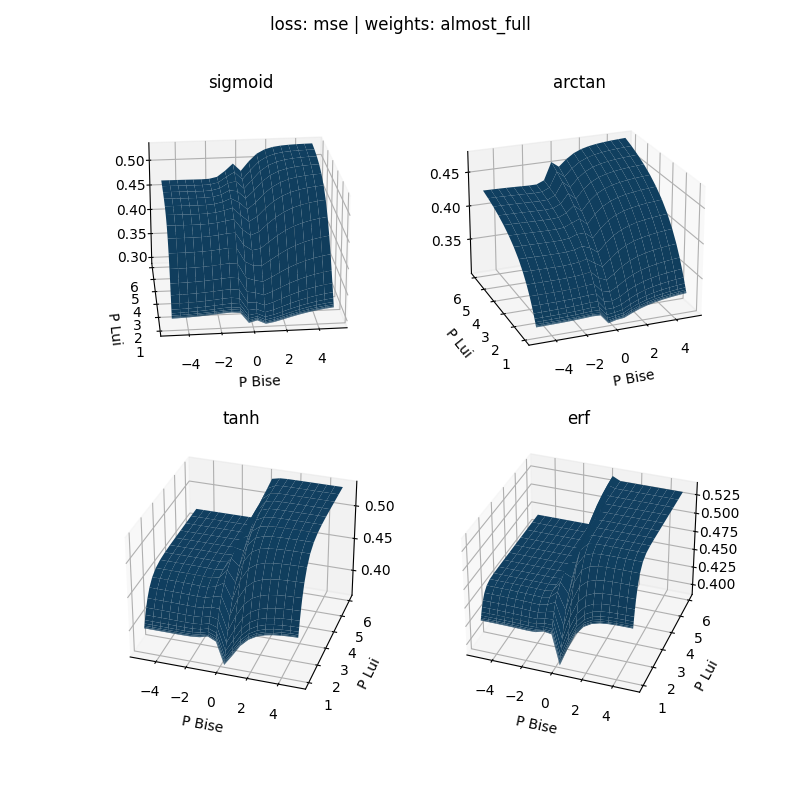

In [120]:
loss_name = "mse"
weight_name = "almost_full"  #almost_full
threshold_modes = ['sigmoid', 'arctan', 'tanh', 'erf',]

plot_landscape(threshold_modes, weight_name, loss_name,)

<IPython.core.display.Javascript object>


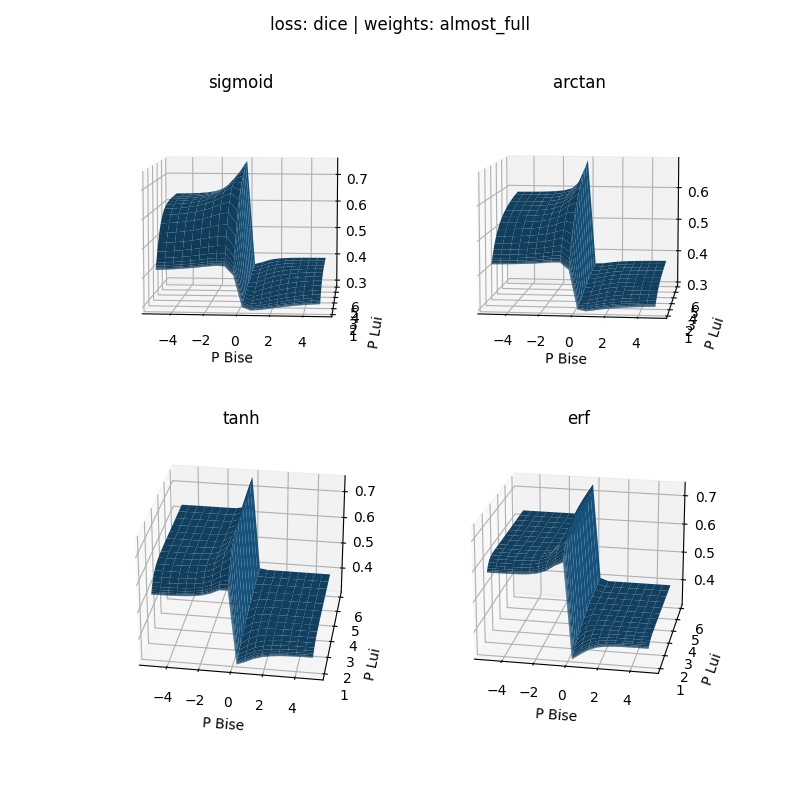

In [121]:
loss_name = "dice"
weight_name = "almost_full"  #almost_full
threshold_modes = ['sigmoid', 'arctan', 'tanh', 'erf',]

plot_landscape(threshold_modes, weight_name, loss_name,)

# Init Analysis

/hdd/aouadt/these/projets/3d_segm/deep_morpho/morp_operations.py:327: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)


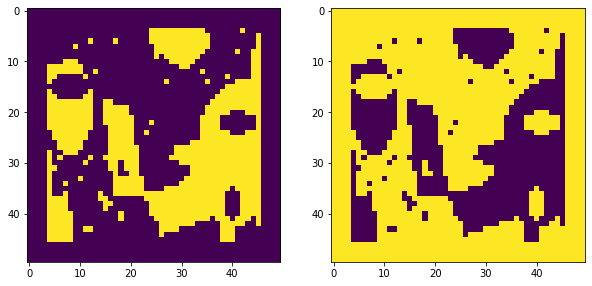

In [4]:
reload_modules()
selem = morp.disk(3)


morp_operation = morpop.ParallelMorpOperations.complementation(3)

# plot_horizontal(morp_operation.selems, morp_operation.operations)

dataloader = mrda.InputOutputGeneratorDataset.get_loader(
    batch_size=32, 
    n_inputs=500_000,
    random_gen_fn=gfo3.get_random_diskorect_channels,
    random_gen_args={'size': (50, 50), 'n_shapes': 20, 'max_shape': (20, 20), 
                     'p_invert': 0.5, 'n_holes': 10, 'max_shape_holes': (10, 10), 
                     'noise_proba': 0.02},
    device=device,
    morp_operation=morp_operation,
)

img, target = next(iter(dataloader))

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.imshow(img[0, 0].cpu().detach())

plt.subplot(122)
plt.imshow(target[0, 0].cpu().detach())


In [38]:
net = bimonn.BiMoNN(
    kernel_size=[7],
    channels=[3, 2],
    atomic_element="bisel",
    threshold_mode="tanh",
    constant_activation_P=False,
    constant_weight_P=True,
    init_weight_identity=False,
)


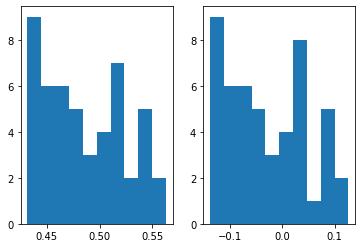

In [35]:
plt.subplot(121)
plt.hist(net.layer1.normalized_weights.detach().view(-1).numpy(),);

plt.subplot(122)
plt.hist(net.layer1.weights.detach().view(-1).numpy(),);


In [39]:
def init_bise_normal_identity(kernel_size, chan_output, std):
    weights = torch.randn(chan_output, kernel_size)[:, None, ...] * std
    weights[..., kernel_size[0] // 2, kernel_size[1] // 2] += 1
    return weights

In [40]:
net.layer1.bises[0].weight.shape

torch.Size([2, 1, 7, 7])